# BAX423 Big Data Analytics - Venmo Transaction Analytics 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# spark
import findspark
findspark.init('/usr/local/appleOwner/apache-spark/3.0.1/libexec')
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import monotonically_increasing_id
import pyspark.sql.functions as F
from pyspark.sql.functions import concat, col, lit, when, max
from pyspark.sql.window import Window

# social network 
import networkx as nx

# emoji and regex
import functools
import operator 
import re
import emoji
from collections import Counter

# regression
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder

# Part 1: Text analytics 

## load dataset 

In [2]:
# initialise sparkContext
spark = SparkSession.builder \
        .master('local[*]') \
        .appName('Venmo') \
        .config('spark.executor.memory', '10gb') \
        .config("spark.cores.max", "8") \
        .config("spark.executor.cores", "6") \
        .getOrCreate()

# read parquet file
df_venmo = spark.read.parquet('VenmoSample.snappy.parquet')

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.executor.cores', '6'),
 ('spark.executor.memory', '10gb'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.port', '54513'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.cores.max', '8'),
 ('spark.driver.host', '10.0.0.225'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1603045200126'),
 ('spark.app.name', 'Venmo'),
 ('spark.ui.showConsoleProgress', 'true')]

In [4]:
print(int(spark.sparkContext.getConf().get('spark.executor.cores','1')))
print(spark._jsc.sc().getExecutorMemoryStatus().size())
print(len(spark.sparkContext._jsc.sc().statusTracker().getExecutorInfos()))

6
1
1


In [ ]:
# count total number of records
df_venmo.count()

7113137

In [5]:
print(spark.sparkContext.defaultParallelism)
print(df_venmo.rdd.getNumPartitions())
df_venmo = df_venmo.repartition(16)
print(df_venmo.rdd.getNumPartitions())

4
4
16


In [ ]:
df_venmo.printSchema()

root
 |-- user1: integer (nullable = true)
 |-- user2: integer (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- description: string (nullable = true)
 |-- is_business: boolean (nullable = true)
 |-- story_id: string (nullable = true)



In [5]:
# add index column and create temporary view
df_venmo = df_venmo.sort(col("user1").desc()).withColumn("index", monotonically_increasing_id())
df_venmo.createOrReplaceTempView("Venmo")
df_venmo.show()

+--------+-------+----------------+-------------------+--------------------+-----------+--------------------+-----+
|   user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|index|
+--------+-------+----------------+-------------------+--------------------+-----------+--------------------+-----+
|16013547|6543786|         payment|2016-11-28 17:08:11|           Christmas|      false|583c647b23e064eac...|    0|
|15995535|2446904|         payment|2016-11-27 23:06:58|                 Mil|      false|583b671223e064eac...|    1|
|15953299| 653552|          charge|2016-11-26 07:55:15|              Hookah|      false|58393fe323e064eac...|    2|
|15932130| 783638|         payment|2016-11-25 16:05:59| Sex. Moeny for sex.|      false|5838616723e064eac...|    3|
|15930503|6330169|         payment|2016-11-25 13:37:23|       Bridal shower|      false|58383e9323e064eac...|    4|
|15928236|7406171|         payment|2016-11-25 05:34:29|                 

## Using the text dictionary and the emoji dictionary to classify Venmo’s transactions in your sample dataset. 

In [6]:
# load word and emoji dictionaries (key words and emojis are classified to 9 major topics)
word_dictionary = pd.read_excel("word dictionary.xlsx")
emoji_dictionary = pd.read_excel("emoji dictionary.xlsx")
emoji_dictionary.head(2)

,People,Food,Event,Activity,Travel,Transportation,Utility,Cash,Illegal/Sarcasm
0,❤️,🍕,👰,🍻,🌴,⛽,🏡,💸,🖕🏿
1,👯,🍵,🎤,🏀,✈️,🅿,💡,💰,☠


In [7]:
# drop n/a values and create a list for each category
people1 = word_dictionary.People.dropna(how='all').values.tolist()
food1 = word_dictionary.Food.dropna(how='all').values.tolist()
event1 = word_dictionary.Event.dropna(how='all').values.tolist()
activity1 = word_dictionary.Activity.dropna(how='all').values.tolist()
travel1 = word_dictionary.Travel.dropna(how='all').values.tolist()
trasportation1 = word_dictionary.Transportation.dropna(how='all').values.tolist()
utility1 = word_dictionary.Utility.dropna(how='all').values.tolist()
cash1 = word_dictionary.Cash.dropna(how='all').values.tolist()
illegal_sarcasm1 = word_dictionary['Illegal/Sarcasm'].dropna(how='all').values.tolist()

people2 = emoji_dictionary.People.dropna(how='all').values.tolist()
food2 = emoji_dictionary.Food.dropna(how='all').values.tolist()
event2 = emoji_dictionary.Event.dropna(how='all').values.tolist()
activity2 = emoji_dictionary.Activity.dropna(how='all').values.tolist()
travel2 = emoji_dictionary.Travel.dropna(how='all').values.tolist()
trasportation2 = emoji_dictionary.Transportation.dropna(how='all').values.tolist()
utility2 = emoji_dictionary.Utility.dropna(how='all').values.tolist()
cash2 = emoji_dictionary.Cash.dropna(how='all').values.tolist()
illegal_sarcasm2 = emoji_dictionary['Illegal/Sarcasm'].dropna(how='all').values.tolist()

In [8]:
# slice dataframe having only emojis
emoji_tbl = spark.sql("select index, description \
                       from Venmo \
                       where HEX(description) REGEXP '^[E2|F0]{2}' \
                               and description NOT REGEXP '[g-zG-Z\\?\\!\\\\\.]'")

emoji_tbl.createOrReplaceTempView("emoji_tbl")
emoji_tbl.show()

+-----+-----------+
|index|description|
+-----+-----------+
|    5|         👗|
|    9|         🅿|
|   13|         🍴|
|   16|     🏷🏷🏷|
|   22|       🏠💸|
|   42|       🎱🎱|
|   57|       🍬🍬|
|   70|         🍕|
|   71|     🏡➡️🚘|
|   74|         🚲|
|   75|         🍜|
|   76|     🍻🍾🍺|
|   83|         🍻|
|  100|         📱|
|  102|         🦄|
|  103|         🦃|
|  109|       🏠💸|
|  116|         🏨|
|  127|         🍕|
|  130|         🍕|
+-----+-----------+
only showing top 20 rows



In [9]:
# slice dataframe having texts or mixed texts and emojis
short_venmo = spark.sql("select index, lower(description) as description from Venmo")
text_tbl = short_venmo.exceptAll(emoji_tbl).sort("index")

text_tbl.createOrReplaceTempView("text_tbl")
text_tbl.show()

+-----+--------------------+
|index|         description|
+-----+--------------------+
|    0|           christmas|
|    1|                 mil|
|    2|              hookah|
|    3| sex. moeny for sex.|
|    4|       bridal shower|
|    6|          coffeeee💘|
|    7|           monicals!|
|    8|            for gift|
|   10|this should cover...|
|   11|              hey 😊|
|   12|        shanghaibest|
|   14|        for sunglass|
|   15|                food|
|   17|                 fag|
|   18|    the wonder years|
|   19|         for friend?|
|   20|            big bear|
|   21|friendsgiving! (f...|
|   23|             toll 🚕|
|   24|       dankest pizza|
+-----+--------------------+
only showing top 20 rows



In [10]:
# text classification
text_class = text_tbl.select("*", 
            when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in people1])), 'people')\
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in food1])), 'food') \
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in event1])), 'event')\
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in activity1])), 'activity')\
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in travel1])), 'travel')\
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in trasportation1])), 'trasportation')\
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in utility1])), 'utility')\
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in cash1])), 'cash')\
 .when(text_tbl.description.rlike("|".join(["(" + pat + ")" for pat in illegal_sarcasm1])), 'illegal_sarcasm')\
                 .otherwise('no_class').alias('class'))

text_class.createOrReplaceTempView("text_class")

# count the number of records that has no class 
x = spark.sql("select * from text_class where class='no_class'")
print("The number of no_class records is", x.count())
text_class.show()

The number of no_class records is 0
+-----+--------------------+-------------+
|index|         description|        class|
+-----+--------------------+-------------+
|    0|           christmas|        event|
|    1|                 mil|         cash|
|    2|              hookah|     activity|
|    3| sex. moeny for sex.|         cash|
|    4|       bridal shower|     activity|
|    6|          coffeeee💘|         food|
|    7|           monicals!|         cash|
|    8|            for gift|     activity|
|   10|this should cover...|trasportation|
|   11|              hey 😊|         cash|
|   12|        shanghaibest|       people|
|   14|        for sunglass|       travel|
|   15|                food|         food|
|   17|                 fag|         cash|
|   18|    the wonder years|         cash|
|   19|         for friend?|       people|
|   20|            big bear|         cash|
|   21|friendsgiving! (f...|       people|
|   23|             toll 🚕|trasportation|
|   24|       dankest

In [11]:
# emoji classification
emoji_class = emoji_tbl.select("*", 
    when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in people2])), 'people')\
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in food2])), 'food') \
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in event2])), 'event')\
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in activity2])), 'activity')\
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in travel2])), 'travel')\
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in trasportation2])), 'trasportation')\
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in utility2])), 'utility')\
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in cash2])), 'cash')\
 .when(emoji_tbl.description.rlike("|".join(["(" + pat + ")" for pat in illegal_sarcasm2])), 'illegal_sarcasm')\
                 .otherwise('no_class').alias('class'))

emoji_class.createOrReplaceTempView("emoji_class")

# count the number of records that has no class 
y = spark.sql("select * from emoji_class where class='no_class'")
print("The number of no_class records is", y.count())
emoji_class.show()

The number of no_class records is 491637
+-----+-----------+-------------+
|index|description|        class|
+-----+-----------+-------------+
|    5|         👗|     no_class|
|    9|         🅿|trasportation|
|   13|         🍴|         food|
|   16|     🏷🏷🏷|     no_class|
|   22|       🏠💸|      utility|
|   42|       🎱🎱|     activity|
|   57|       🍬🍬|         food|
|   70|         🍕|         food|
|   71|     🏡➡️🚘|trasportation|
|   74|         🚲|     activity|
|   75|         🍜|         food|
|   76|     🍻🍾🍺|         food|
|   83|         🍻|     activity|
|  100|         📱|      utility|
|  102|         🦄|     no_class|
|  103|         🦃|     no_class|
|  109|       🏠💸|      utility|
|  116|         🏨|     activity|
|  127|         🍕|         food|
|  130|         🍕|         food|
+-----+-----------+-------------+
only showing top 20 rows



In [12]:
# union text and emoji dataset
df_class = spark.sql("select * from text_class union select * from emoji_class order by index")
df_class.createOrReplaceTempView("df_class")
df_class.show()

+-----+--------------------+-------------+
|index|         description|        class|
+-----+--------------------+-------------+
|    0|           christmas|        event|
|    1|                 mil|         cash|
|    2|              hookah|     activity|
|    3| sex. moeny for sex.|         cash|
|    4|       bridal shower|     activity|
|    5|                  👗|     no_class|
|    6|          coffeeee💘|         food|
|    7|           monicals!|         cash|
|    8|            for gift|     activity|
|    9|                  🅿|trasportation|
|   10|this should cover...|trasportation|
|   11|              hey 😊|         cash|
|   12|        shanghaibest|       people|
|   13|                  🍴|         food|
|   14|        for sunglass|       travel|
|   15|                food|         food|
|   16|              🏷🏷🏷|     no_class|
|   17|                 fag|         cash|
|   18|    the wonder years|         cash|
|   19|         for friend?|       people|
+-----+------------

## Q2 What is the percent of emoji only transactions? Which are the top 5 most popular emoji? Which are the top three most popular emoji categories? 

**What is the percent of emoji only transactions?**

In [14]:
emoji_per = emoji_tbl.count()/df_venmo.count()
emoji_per

0.2621712473694799

**Which are the top 5 most popular emoji?**

In [15]:
# create emoji list
emoji_list = emoji_tbl.select("description").rdd.flatMap(lambda x: x).collect()
len(emoji_list)

1864860

In [16]:
# split emoji_list[0] as the starter
em_split_emoji = emoji.get_emoji_regexp().split(emoji_list[0])
em_split_whitespace = [substr.split() for substr in em_split_emoji]
split_emoji_list = functools.reduce(operator.concat, em_split_whitespace)

# extend list starting from emoji_list[0]
for i in range(len(emoji_list)-1):
    next_emoji = "".join(emoji_list[i+1].split()) 
    split_emoji_list.extend(next_emoji)

# filter out empty elements
split_emoji_list = list(filter(lambda x: x != '️', split_emoji_list))

# count emoji frequency and find top 5 popular emojis
emoji_freq = Counter(split_emoji_list)
emoji_freq.most_common(5)

[('🍕', 186979), ('🍻', 114195), ('💸', 91973), ('🍷', 88363), ('🍺', 70590)]

**Which are the top three most popular emoji categories?**

In [ ]:
# group by class and aggregate emojis in each class
agg_class = emoji_class.groupby("class")\
           .agg(F.concat_ws("", F.collect_list(emoji_class.description)).alias('agg_emojis'))
agg_class.registerTempTable("agg_class")

# transfer to pandas dataframe
pandas_venmo = agg_class.select("*").toPandas()
pandas_venmo.head()

,class,agg_emojis
0,travel,🌴🌴🌴🐟🐠🐟🐠🐟🌴🌴🌴✈️🚌🚡🚡🚡🚡🚡🚡🚡🚡🚡🚡💒✈️✈️🇭🇷🇭🇷🇭🇷🌴🌴✈️🌴✈️🏣🇮🇪🔵...
1,no_class,⚡⚡️🇺🇸🎯👃🏻👃🏽👃🏿🐍🔥🔥🔥💦💦💦👣⚡️🕶🐭👅⛄️🌏✒️✒️✒️💆🏼👻👻👻💚☘🤖✨👕👧🚛...
2,utility,🏡💡🔌📺📺📺⚡🔌💡💸🏡⚡🔌💡💸🚒💦🔥🖥🖥🏡⚡🔌💡💸🛁👩‍👩‍👧🏡🏠📺💸🔑🏠💸🏡💸📺📺💻💦🔌🔥...
3,food,🍺🍕🍕🍕🍕🍴🍴🍴☕️🍴🍰🍳🎂🌮🍵☕🍷🍷🍷🍰🍰🍰🍰🍰🍪🍪🍪🍺🍺🍇🍌🍓🍹🚗➡️🍟🍺🍕🍕🍕🍕🍕🍕🍷...
4,cash,💰🇮🇱🤑💰⛏⚱🤑💰🤑🤑🤑🤑🤑💵💸💰💵💵🌟💸💦💸💰🤑💸💰💰💦💸💰🏧💰 🔙💰💵💸💵💵💸💵🔙💸💦💸...


In [ ]:
# If remove the no_class, "Food", "Activity", and "People" are the top 3 emoji categories
x = pandas_venmo.groupby("class")["agg_emojis"]\
            .apply(lambda x: x.str.len()).reset_index().sort_values("agg_emojis", ascending=False)

class_cnt = pd.concat([pandas_venmo["class"],x], axis=1).sort_values("agg_emojis", ascending=False)
class_cnt.head(10)

,class,index,agg_emojis
3,food,3,1667773
1,no_class,1,1056768
8,activity,8,591270
5,people,5,457549
2,utility,2,365662
7,trasportation,7,187082
9,event,9,110588
0,travel,0,107989
6,illegal_sarcasm,6,86135
4,cash,4,84001


## For each user, creating a variable to indicate their spending behavior profile.  

In [ ]:
# join Venmo original dataset with the dataset from question 1 that has description classification
# consider the transaction direction: only keep transactions that type is 'payment'
df_full = spark.sql("select user1, user2, t1.description, class, datetime \
                    from df_class t1 join Venmo t2 using (index) \
                    where transaction_type = 'payment' \
                    order by user1 ")
df_full.createOrReplaceTempView("df_full")
df_full.show(4)

+-----+-------+--------------------+--------+-------------------+
|user1|  user2|         description|   class|           datetime|
+-----+-------+--------------------+--------+-------------------+
|    2|    220|             cooking|    food|2012-11-23 06:03:42|
|    3|1079020|late night loooov...|activity|2016-10-07 23:37:56|
|    3|     52|                  🍕|    food|2016-09-22 15:30:09|
|    3|     52|           zeet zeet|    cash|2016-09-22 15:30:09|
+-----+-------+--------------------+--------+-------------------+
only showing top 4 rows



In [ ]:
# For each user, calculate the number of his/her transactions per class and how many percents of total spendings 
df_profile = spark.sql("select user1, class, count(*) as transactions_per_class, \
                    concat(round(count(*)/sum(count(*)) over (partition by user1) *100, 2),'%') as ratio \
               from df_full \
               group by user1, class \
               order by user1")
df_profile.show()

+-----+-------------+----------------------+------+
|user1|        class|transactions_per_class| ratio|
+-----+-------------+----------------------+------+
|    2|       people|                     1|100.0%|
|    3|     activity|                     1|14.29%|
|    3|         food|                     1|14.29%|
|    3|         cash|                     1|14.29%|
|    3|       travel|                     1|14.29%|
|    3|       people|                     3|42.86%|
|    4|       people|                     2|33.33%|
|    4|         cash|                     3| 50.0%|
|    4|         food|                     1|16.67%|
|   10|     activity|                     1| 9.09%|
|   10|         cash|                     1| 9.09%|
|   10|         food|                     6|54.55%|
|   10|       people|                     3|27.27%|
|   11|       travel|                     1| 2.86%|
|   11|      utility|                     2| 5.71%|
|   11|     activity|                     4|11.43%|
|   11|     

In [ ]:
# create a list with unique classes 
categories = sorted(df_profile.select("class").distinct().rdd.map(lambda row: row[0]).collect())

cols = [when(col("class") == category, col("ratio")).otherwise(None).alias(category) 
    for category in categories]

maxs = [max(col(category)).alias(category) for category in categories]

# create static spending profile for each user
static_profile = (df_profile.select(col("user1"), *cols).groupBy("user1").agg(*maxs).na.fill(0))

static_profile.createOrReplaceTempView("static_profile")
static_profile.show()

+-----+--------+------+-----+------+---------------+--------+------+-------------+------+-------+
|user1|activity|  cash|event|  food|illegal_sarcasm|no_class|people|trasportation|travel|utility|
+-----+--------+------+-----+------+---------------+--------+------+-------------+------+-------+
| 2866|    null|100.0%| null|  null|           null|    null|  null|         null|  null|   null|
| 6620|    null|  null| null|  null|           null|    null|  null|         null|100.0%|   null|
|28170|    null|100.0%| null|  null|           null|    null|  null|         null|  null|   null|
|28759|    null| 25.0%| null|  null|           null|   25.0%|  null|        25.0%|  null|  25.0%|
|29894|    null|  null| null| 50.0%|           null|    null|  null|        50.0%|  null|   null|
|33602|  21.43%|21.43%| null|14.29%|           null|    null|35.71%|         null|  null|  7.14%|
|36525|    null|33.33%| null|33.33%|           null|  33.33%|  null|         null|  null|   null|
|47283|   25.0%|  nu

In [ ]:
# df_profile = df_profile.withColumn("dict", concat(col("ratio"), lit(" "), col("class")))
# df_profile = df_profile.groupby("user1").agg(F.concat_ws(", ", 
#                                     F.collect_list(df_profile.dict)).alias("static_profile"))
# df_profile.registerTempTable("df_profile")
# df_profile.show(10, truncate = False)

+-----+---------------------------------------------------------------------------------------------------------+
|user1|static_profile                                                                                           |
+-----+---------------------------------------------------------------------------------------------------------+
|2    |100.0%people                                                                                             |
|3    |16.67%no_class, 50.0%people, 16.67%travel, 16.67%food                                                    |
|4    |16.67%illegal_sarcasm, 16.67%food, 33.33%people, 16.67%activity, 16.67%no_class                          |
|10   |10.0%no_class, 30.0%people, 10.0%activity, 50.0%food                                                     |
|11   |4.0%activity, 36.0%people, 4.0%illegal_sarcasm, 20.0%no_class, 20.0%food, 8.0%travel, 8.0%utility        |
|12   |33.33%people, 11.11%activity, 33.33%no_class, 11.11%food, 11.11%illegal_sarcasm  

## For each user, creating a dynamic spending profile (12 months)

In [ ]:
# navigate the first transaction date and only keep first 12 months transactions for each user 
days_tbl = spark.sql("select user1, user2, datetime, class, datediff(datetime, \
                first_value(datetime) over (partition by user1 order by datetime)) as days \
                from df_full \
                group by user1, user2, datetime, class\
                order by user1")
days_tbl.show()

+-----+-------+-------------------+-------------+----+
|user1|  user2|           datetime|        class|days|
+-----+-------+-------------------+-------------+----+
|    2|    220|2012-11-23 06:03:42|         food|   0|
|    3|2382556|2016-10-07 08:50:23|       people|  15|
|    3|     52|2016-09-22 15:30:09|         food|   0|
|    3|1079020|2016-10-07 23:37:56|     activity|  15|
|    3|     52|2016-09-22 15:30:09|         cash|   0|
|    3|7854140|2016-10-09 03:36:13|         cash|  17|
|    3|2382556|2016-10-06 10:49:45|         cash|  14|
|    3|1204190|2016-10-09 01:56:24|      utility|  17|
|    3|7854140|2016-10-09 03:36:13|         food|  17|
|    4| 122744|2012-12-03 03:35:53|         cash|   0|
|    4| 125527|2012-12-15 05:51:12|       travel|  12|
|    4|9271982|2016-03-03 12:45:57|         cash|1186|
|    4| 968271|2014-02-04 06:51:33|         cash| 428|
|    4| 221578|2016-04-17 03:35:09|       people|1231|
|   10|    255|2013-01-14 08:18:43|         cash|  50|
|   10|   

In [ ]:
# add lifetime indiactor (0-12 where 0 represents the 1st transaction and 1 represents 1 month and so on)
days_lifeindicator_tbl = days_tbl.select("*", 
            when(days_tbl.days==0, 0)\
         .when((days_tbl.days>0) & (days_tbl.days<=30), 1) \
         .when((days_tbl.days>30) & (days_tbl.days<=60), 2) \
         .when((days_tbl.days>60) & (days_tbl.days<=90), 3)\
         .when((days_tbl.days>90) & (days_tbl.days<=120), 4)\
         .when((days_tbl.days>120) & (days_tbl.days<=150), 5)\
         .when((days_tbl.days>150) & (days_tbl.days<=180), 6)\
         .when((days_tbl.days>180) & (days_tbl.days<=210), 7)\
         .when((days_tbl.days>210) & (days_tbl.days<=240), 8)\
         .when((days_tbl.days>240) & (days_tbl.days<=270), 9)\
         .when((days_tbl.days>270) & (days_tbl.days<=300), 10)\
         .when((days_tbl.days>300) & (days_tbl.days<=330), 11)\
         .when((days_tbl.days>330) & (days_tbl.days<=360), 12)\
         .otherwise(-1).alias('lifetime_indicator'))
days_lifeindicator_tbl.createOrReplaceTempView("days_lifeindicator_tbl")

# filter out records where "datetime-startdate">=360 days (12 months after first transaction)
lifetime_tbl = days_lifeindicator_tbl.filter("lifetime_indicator != -1 ").sort("user1")

lifetime_tbl.show()

+-----+-------+-------------------+-------------+----+------------------+
|user1|  user2|           datetime|        class|days|lifetime_indicator|
+-----+-------+-------------------+-------------+----+------------------+
|    2|    220|2012-11-23 06:03:42|         food|   0|                 0|
|    3|1079020|2016-10-07 23:37:56|     activity|  15|                 1|
|    3|7854140|2016-10-09 03:36:13|         cash|  17|                 1|
|    3|2382556|2016-10-07 08:50:23|       people|  15|                 1|
|    3|     52|2016-09-22 15:30:09|         cash|   0|                 0|
|    3|1204190|2016-10-09 01:56:24|      utility|  17|                 1|
|    3|7854140|2016-10-09 03:36:13|         food|  17|                 1|
|    3|2382556|2016-10-06 10:49:45|         cash|  14|                 1|
|    3|     52|2016-09-22 15:30:09|         food|   0|                 0|
|    4| 125527|2012-12-15 05:51:12|       travel|  12|                 1|
|    4| 122744|2012-12-03 03:35:53|   

In [ ]:
lifetime_tbl = lifetime_tbl\
        .withColumn("lifetime_category", 
                        concat(lit("time"), col("lifetime_indicator"), lit("_"), col("class")))\
        .withColumn("user_life", concat(col("user1"), lit("_"), col("lifetime_indicator")))

lifetime_tbl.createOrReplaceTempView("lifetime_tbl")

dynamic_tbl = spark.sql("select user1, lifetime_indicator, class, \
                round(count(*)/sum(count(*)) \
                  over (partition by user1, lifetime_indicator), 2) as percentage \
               from lifetime_tbl \
               group by user1, lifetime_indicator, class \
               order by user1")

dynamic_tbl.createOrReplaceTempView("dynamic_tbl")

dynamic_tbl.show()

+-----+------------------+-------------+----------+
|user1|lifetime_indicator|        class|percentage|
+-----+------------------+-------------+----------+
|    2|                 0|         food|       1.0|
|    3|                 1|       people|      0.17|
|    3|                 1|      utility|      0.17|
|    3|                 1|         cash|      0.33|
|    3|                 1|         food|      0.17|
|    3|                 0|         cash|       0.5|
|    3|                 1|     activity|      0.17|
|    3|                 0|         food|       0.5|
|    4|                 0|         cash|       1.0|
|    4|                 1|       travel|       1.0|
|   10|                 0|trasportation|       1.0|
|   10|                 4|trasportation|       0.5|
|   10|                 2|     activity|       0.5|
|   10|                 2|         cash|       0.5|
|   10|                 1|         food|       1.0|
|   10|                 4|         cash|       0.5|
|   10|     

In [ ]:
# create dynamic profile
#spread rows to columns: each row representing one user, each column representing lifetime and spending category

classes = sorted(dynamic_tbl.select("class").distinct().rdd.map(lambda row: row[0]).collect())

cols1 = [when(col("class") == clas, col("percentage")).otherwise(None).alias(clas) 
    for clas in classes]

maxs1 = [max(col(clas)).alias(clas) for clas in classes]

dynamic_profile = (dynamic_tbl.select(col("user1"), 
            col("lifetime_indicator"), *cols1)\
            .groupBy("user1", "lifetime_indicator").agg(*maxs1).na.fill(0)\
            .orderBy("user1", "lifetime_indicator"))

dynamic_profile.createOrReplaceTempView("dynamic_profile")

dynamic_profile.show()

+-----+------------------+--------+----+-----+----+---------------+--------+------+-------------+------+-------+
|user1|lifetime_indicator|activity|cash|event|food|illegal_sarcasm|no_class|people|trasportation|travel|utility|
+-----+------------------+--------+----+-----+----+---------------+--------+------+-------------+------+-------+
|    2|                 0|     0.0| 0.0|  0.0| 1.0|            0.0|     0.0|   0.0|          0.0|   0.0|    0.0|
|    3|                 0|     0.0| 0.5|  0.0| 0.5|            0.0|     0.0|   0.0|          0.0|   0.0|    0.0|
|    3|                 1|    0.17|0.33|  0.0|0.17|            0.0|     0.0|  0.17|          0.0|   0.0|   0.17|
|    4|                 0|     0.0| 1.0|  0.0| 0.0|            0.0|     0.0|   0.0|          0.0|   0.0|    0.0|
|    4|                 1|     0.0| 0.0|  0.0| 0.0|            0.0|     0.0|   0.0|          0.0|   1.0|    0.0|
|   10|                 0|     0.0| 0.0|  0.0| 0.0|            0.0|     0.0|   0.0|          1.0

In [ ]:
df1 = spark.sql("select user1, category_life, \
                 round(count(*)/sum(count(*)) over (partition by user_life), 2) as percentage \
               from lifetime_tbl \
               group by user1, user_life, category_life \
               order by user1")
life_cates = sorted(df1.select("category_life").distinct().rdd.map(lambda row: row[0]).collect())
cols2 = [when(col("category_life") == life_cate, col("percentage")).otherwise(None).alias(life_cate) 
    for life_cate in life_cates]
maxs2 = [max(col(life_cate)).alias(life_cate) for life_cate in life_cates]
dynamic2 = (df1.select(col("user1"), *cols2).groupBy("user1").agg(*maxs2).na.fill(0))


# calculate mean, standard deviation for each time period and each class
summary_stats = dynamic2.summary()
df_dynamic_summary = summary_stats.select("*").toPandas()
df_dynamic_summary = df_dynamic_summary.T.reset_index() # transpose and reset index
headers = df_dynamic_summary.iloc[0] # store new header values
df_dynamic_summary = df_dynamic_summary[2:] # remove user1 information and previous header
df_dynamic_summary.columns = headers
df_dynamic_summary = df_dynamic_summary.reset_index(drop=True)
df_dynamic_summary.head()

,summary,count,mean,stddev,min,25%,50%,75%,max
0,time0_activity,2158528,0.12843825051145957,0.33406685333468933,0.0,0.0,0.0,0.0,1.0
1,time0_cash,2158528,0.2513680156106382,0.43303739637783334,0.0,0.0,0.0,0.6,1.0
2,time0_event,2158528,0.013661930723159488,0.11592848163120395,0.0,0.0,0.0,0.0,1.0
3,time0_food,2158528,0.23720214887182375,0.4246861125589359,0.0,0.0,0.0,0.0,1.0
4,time0_illegal_sarcasm,2158528,0.004347671190737391,0.06568058689262556,0.0,0.0,0.0,0.0,1.0


In [ ]:
# add time and category columns for plotting 
time = []
category = []

for i in range(len(df_dynamic_summary)):
    pos = df_dynamic_summary.summary[i].index("_")
    c = df_dynamic_summary.summary[i][pos+1:]  # get category
    t = df_dynamic_summary.summary[i][4:pos]   # get lifetime
    time.append(t)
    category.append(c)

df_dynamic_summary["time"] = time
df_dynamic_summary["category"] = category

# convert data type from string to numeric 
df_dynamic_summary["time"] = df_dynamic_summary["time"].apply(pd.to_numeric, errors='coerce')
df_dynamic_summary["mean"] = df_dynamic_summary["mean"].apply(pd.to_numeric, errors='coerce')
df_dynamic_summary["stddev"] = df_dynamic_summary["stddev"].apply(pd.to_numeric, errors='coerce')
df_dynamic_summary["2std"] = 2*df_dynamic_summary["stddev"]

df_dynamic_summary.head()

,summary,count,mean,stddev,min,25%,50%,75%,max,time,category,2std
0,time0_activity,2158528,0.128438,0.334067,0.0,0.0,0.0,0.0,1.0,0,activity,0.668134
1,time0_cash,2158528,0.251368,0.433037,0.0,0.0,0.0,0.6,1.0,0,cash,0.866075
2,time0_event,2158528,0.013662,0.115928,0.0,0.0,0.0,0.0,1.0,0,event,0.231857
3,time0_food,2158528,0.237202,0.424686,0.0,0.0,0.0,0.0,1.0,0,food,0.849372
4,time0_illegal_sarcasm,2158528,0.004348,0.065681,0.0,0.0,0.0,0.0,1.0,0,illegal_sarcasm,0.131361


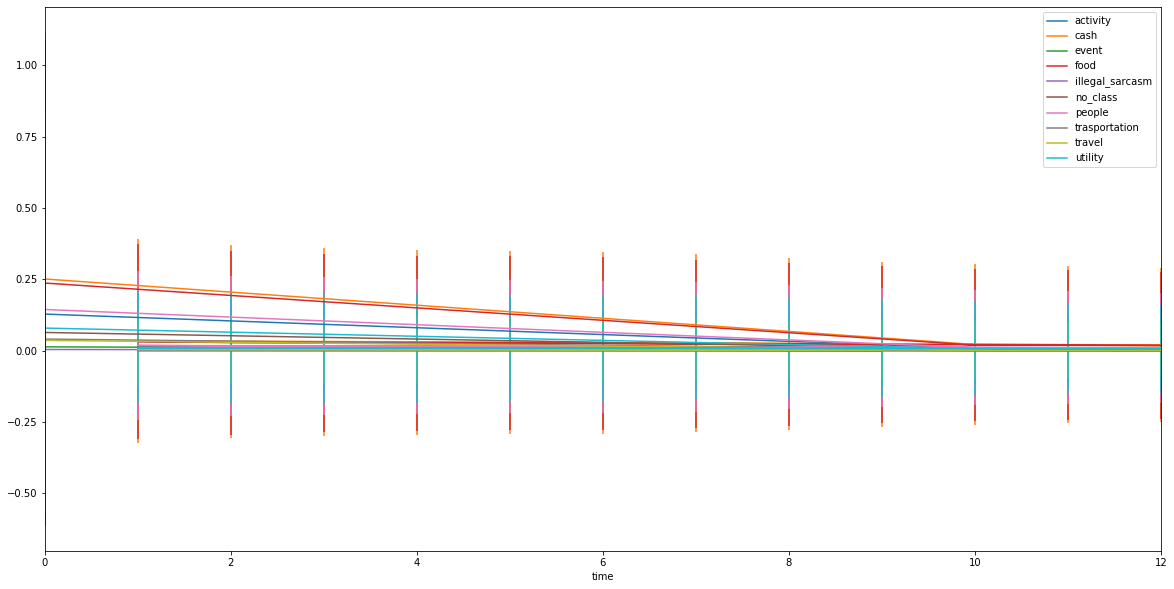

In [ ]:
# after lifetime 10, the means for all categories' spendings tend to be stable and close to zero. 
fig, ax = plt.subplots(figsize=(20, 10))

for key, group in df_dynamic_summary.groupby('category'):
    group.plot('time', 'mean', yerr='2std', label=key, ax=ax) 

plt.show()

# Part 2: Social network analytics 

## Finding a user’s friends and friends of friends 

In [ ]:
# find user's friends
df_friends = spark.sql("select distinct user1 as user, user2 as friends \
                   from \
                    (select distinct user1, user2 from Venmo \
                    union select distinct user2, user1 from Venmo) T\
                   order by user, friends")

df_friends.createOrReplaceTempView("df_friends")
df_friends.show()

+----+-------+
|user|friends|
+----+-------+
|   2|     43|
|   2|    220|
|   2| 191142|
|   3|     43|
|   3|     52|
|   3| 263437|
|   3| 567957|
|   3|1079020|
|   3|1204190|
|   3|2382556|
|   3|7854140|
|   4| 122744|
|   4| 125527|
|   4| 125755|
|   4| 187560|
|   4| 221578|
|   4| 968271|
|   4|9271982|
|   6| 676003|
|   6| 688883|
+----+-------+
only showing top 20 rows



In [ ]:
# full table of user, friends, and friends of friends (remove user itself)
# may contain some duplicates in friends and fof columns
df_edges = spark.sql("select t1.user as user, t1.friends as friends, \
                            t2.friends as fof \
                      from df_friends t1, df_friends t2 \
                      where t1.friends=t2.user and t2.friends<>t1.user \
                      order by t1.user, t1.friends, t2.friends ")

df_edges.createOrReplaceTempView("df_edges")
df_edges.show()

+----+-------+-------+
|user|friends|    fof|
+----+-------+-------+
|   2|     43|      3|
|   2|     43|     10|
|   2|     43|     19|
|   2|     43|     96|
|   2|     43|    629|
|   2|     43|   3565|
|   2|     43|  20530|
|   2|     43|  20639|
|   2|     43|  47104|
|   2|     43|  49778|
|   2|     43|  55895|
|   2|     43|  72106|
|   2|     43|  82697|
|   2|     43| 183628|
|   2|     43| 276439|
|   2|     43| 297967|
|   2|     43| 307603|
|   2|     43| 316862|
|   2|     43|1491816|
|   2| 191142| 613769|
+----+-------+-------+
only showing top 20 rows



In [ ]:
# find user's friends of friends (remove potential duplicates in fof and friends)
df_fof = spark.sql("select t1.user, fof \
                   from df_edges t1 \
                      left join (select user, friends from df_friends) t2 \
                        on t1.user=t2.user and t1.fof=t2.friends \
                   where fof is null or t2.friends is null \
                   order by t1.user, fof ")
df_fof.createOrReplaceTempView("df_fof")
df_fof.show()

+----+------+
|user|   fof|
+----+------+
|   2|     3|
|   2|    10|
|   2|    19|
|   2|    96|
|   2|   629|
|   2|  3565|
|   2| 20530|
|   2| 20639|
|   2| 47104|
|   2| 49778|
|   2| 55895|
|   2| 72106|
|   2| 82697|
|   2|183628|
|   2|276439|
|   2|297967|
|   2|307603|
|   2|316862|
|   2|613769|
|   2|851628|
+----+------+
only showing top 20 rows



Describe your algorithm and calculate its computational complexity. Can you do it better?

In [8]:
# friends computational complexity 
df_friends_computationalexplain = df_friends.explain()

== Physical Plan ==
*(8) Sort [user#60 ASC NULLS FIRST, friends#61 ASC NULLS FIRST], true, 0
+- Exchange rangepartitioning(user#60 ASC NULLS FIRST, friends#61 ASC NULLS FIRST, 200)
   +- *(7) HashAggregate(keys=[user#60, friends#61], functions=[])
      +- Exchange hashpartitioning(user#60, friends#61, 200)
         +- *(6) HashAggregate(keys=[user#60, friends#61], functions=[])
            +- *(6) HashAggregate(keys=[user1#0, user2#1], functions=[])
               +- Exchange hashpartitioning(user1#0, user2#1, 200)
                  +- *(5) HashAggregate(keys=[user1#0, user2#1], functions=[])
                     +- Union
                        :- *(2) HashAggregate(keys=[user1#0, user2#1], functions=[])
                        :  +- Exchange hashpartitioning(user1#0, user2#1, 200)
                        :     +- *(1) HashAggregate(keys=[user1#0, user2#1], functions=[])
                        :        +- *(1) Project [user1#0, user2#1]
                        :           +- *(1) Fi

In [9]:
# friends of friends computational complexity 
df_fof_computationalexplain = df_fof.explain()

== Physical Plan ==
*(32) Sort [user#64 ASC NULLS FIRST, fof#66 ASC NULLS FIRST], true, 0
+- Exchange rangepartitioning(user#64 ASC NULLS FIRST, fof#66 ASC NULLS FIRST, 200)
   +- *(31) Project [user#64, fof#66]
      +- *(31) Filter (isnull(fof#66) || isnull(friends#61))
         +- SortMergeJoin [user#64, fof#66], [user#60, friends#61], LeftOuter
            :- *(21) Sort [user#64 ASC NULLS FIRST, fof#66 ASC NULLS FIRST], false, 0
            :  +- Exchange hashpartitioning(user#64, fof#66, 200)
            :     +- *(20) Project [user#64, fof#66]
            :        +- *(20) Sort [user#60 ASC NULLS FIRST, friends#61 ASC NULLS FIRST, friends#68 ASC NULLS FIRST], true, 0
            :           +- Exchange rangepartitioning(user#60 ASC NULLS FIRST, friends#61 ASC NULLS FIRST, friends#68 ASC NULLS FIRST, 200)
            :              +- *(19) Project [user#60 AS user#64, friends#68 AS fof#66, user#60, friends#61, friends#68]
            :                 +- *(19) SortMergeJoin [frie

## Using the dynamic analysis from before, and calculate the social network metrics across a user’s lifetime in Venmo 

### i) Number of friends and number of friends of friends

**Number of friends**

In [ ]:
# discrete lifetime and number of friends
df_dynamic_friendcnt = spark.sql("select distinct user1 as user, lifetime_indicator, \
                             count(distinct user2) as friends_cnt \
                   from \
                    (select distinct user1, user2, lifetime_indicator from lifetime_tbl \
                    union select distinct user2, user1, lifetime_indicator from lifetime_tbl) T\
                   group by user, lifetime_indicator \
                   order by user")

df_dynamic_friendcnt.createOrReplaceTempView("df_dynamic_friendcnt")
df_dynamic_friendcnt.show()

+----+------------------+-----------+
|user|lifetime_indicator|friends_cnt|
+----+------------------+-----------+
|   2|                 0|          1|
|   3|                 1|          4|
|   3|                 0|          1|
|   4|                 0|          3|
|   4|                 1|          1|
|   6|                 0|          2|
|   6|                 5|          1|
|   8|                 0|          2|
|   8|                 9|          1|
|   8|                10|          1|
|   8|                 2|          1|
|   8|                 7|          1|
|   9|                 5|          1|
|   9|                 2|          1|
|   9|                 7|          1|
|   9|                 0|          1|
|   9|                 8|          1|
|  10|                12|          1|
|  10|                 6|          1|
|  10|                 4|          2|
+----+------------------+-----------+
only showing top 20 rows



In [ ]:
# create continuous user lifetime
lst = [0,1,2,3,4,5,6,7,8,9,10,11,12]
df_usertime = df_dynamic_friendcnt.select("user").withColumn("time_lst", F.array([F.lit(x) for x in lst]))
df_usertime = df_usertime.withColumn("time_lst", F.explode(col("time_lst")))
df_usertime.createOrReplaceTempView("df_usertime")

df_lifetime_friends = spark.sql("select user, lifetime_indicator, \
                            max(ifnull(friends_cnt,0)) as friends_cnt \
                        from \
                        (select user, lifetime_indicator, friends_cnt from df_dynamic_friendcnt \
                          union \
                         select user, time_lst, null as friends_cnt from df_usertime) T \
                        group by user, lifetime_indicator \
                        order by user, lifetime_indicator")
df_lifetime_friends.createOrReplaceTempView("df_lifetime_friends")
df_lifetime_friends.show()

+----+------------------+-----------+
|user|lifetime_indicator|friends_cnt|
+----+------------------+-----------+
|   2|                 0|          1|
|   2|                 1|          0|
|   2|                 2|          0|
|   2|                 3|          0|
|   2|                 4|          0|
|   2|                 5|          0|
|   2|                 6|          0|
|   2|                 7|          0|
|   2|                 8|          0|
|   2|                 9|          0|
|   2|                10|          0|
|   2|                11|          0|
|   2|                12|          0|
|   3|                 0|          1|
|   3|                 1|          4|
|   3|                 2|          0|
|   3|                 3|          0|
|   3|                 4|          0|
|   3|                 5|          0|
|   3|                 6|          0|
+----+------------------+-----------+
only showing top 20 rows



In [ ]:
# continuous lifetime, number of friends, cumulative number of friends
df_dynamic_cum_friends = spark.sql("select user, lifetime_indicator, friends_cnt, \
                                        (sum(friends_cnt) over (partition by user \
                                        order by lifetime_indicator)) as cum_friends \
                                    from df_lifetime_friends \
                                    order by user, lifetime_indicator ")

df_dynamic_cum_friends.createOrReplaceTempView("df_dynamic_cum_friends")
df_dynamic_cum_friends.show()

+----+------------------+-----------+-----------+
|user|lifetime_indicator|friends_cnt|cum_friends|
+----+------------------+-----------+-----------+
|   2|                 0|          1|          1|
|   2|                 1|          0|          1|
|   2|                 2|          0|          1|
|   2|                 3|          0|          1|
|   2|                 4|          0|          1|
|   2|                 5|          0|          1|
|   2|                 6|          0|          1|
|   2|                 7|          0|          1|
|   2|                 8|          0|          1|
|   2|                 9|          0|          1|
|   2|                10|          0|          1|
|   2|                11|          0|          1|
|   2|                12|          0|          1|
|   3|                 0|          1|          1|
|   3|                 1|          4|          5|
|   3|                 2|          0|          5|
|   3|                 3|          0|          5|


**Number of friends of friends**

In [ ]:
# number of friends of friends for each user lifetime
# step 1: find freinds and friends of friends for each user lifetime
dynamic_friends = spark.sql("select user1 as user, user2 as friends, lifetime_indicator \
                   from \
                    (select distinct user1, user2, lifetime_indicator from lifetime_tbl \
                    union \
                    select distinct user2, user1, lifetime_indicator from lifetime_tbl) T\
                   order by user, lifetime_indicator, friends")

dynamic_friends.createOrReplaceTempView("dynamic_friends")

df_dynamic_edges = spark.sql("select d1.user, d1.friends, d2.friends as fof, \
                            d1.lifetime_indicator \
                        from dynamic_friends d1, dynamic_friends d2 \
                        where d1.friends=d2.user \
                            and d1.lifetime_indicator = d2.lifetime_indicator \
                            and d2.friends<>d1.user \
                        order by d1.user, d1.lifetime_indicator")
df_dynamic_edges.createOrReplaceTempView("df_dynamic_edges")

In [ ]:
# step 2: deal with situation when user's friends of friends are also in friends list 
df_dynamic_fof = spark.sql("select t1.user, fof, t1.lifetime_indicator \
                   from df_dynamic_edges t1 \
                        left join (select user, friends, \
                            lifetime_indicator from dynamic_friends) t2 \
                        on t1.user=t2.user \
                        and t1.lifetime_indicator=t2.lifetime_indicator \
                        and t1.fof=t2.friends \
                   where fof is null or t2.friends is null \
                   order by t1.user, t1.lifetime_indicator, fof")

df_dynamic_fof.createOrReplaceTempView("df_dynamic_fof")
df_dynamic_fof.show()

+----+-------+------------------+
|user|    fof|lifetime_indicator|
+----+-------+------------------+
|   3|    225|                 0|
|   3|1400679|                 1|
|   6|    485|                 5|
|   6|2566210|                 5|
|   8|2734056|                 2|
|   8| 704469|                10|
|   9| 378439|                 0|
|   9| 737443|                 0|
|   9|4095326|                 0|
|   9|2171178|                 5|
|   9| 441736|                 8|
|  10|  66916|                 0|
|  10| 276439|                 1|
|  10|     19|                 2|
|  10|  47104|                 2|
|  10|  55895|                 4|
|  10|  47104|                 9|
|  10|  49778|                 9|
|  11|  66374|                 0|
|  11|  67855|                 0|
+----+-------+------------------+
only showing top 20 rows



In [ ]:
# step 3: calculate number of fof for each lifetime
df_dynamic_fofcnt = spark.sql("select distinct user, lifetime_indicator, \
                    count(distinct fof) as fof_cnt \
                  from ( \
                      select d1.user, fof, d1.lifetime_indicator \
                      from dynamic_friends d1 left join df_dynamic_fof d2 \
                      on d1.user=d2.user \
                        and d1.lifetime_indicator=d2.lifetime_indicator) T \
                  group by user, lifetime_indicator \
                  order by user, lifetime_indicator")

df_dynamic_fofcnt.createOrReplaceTempView("df_dynamic_fofcnt")
df_dynamic_fofcnt.show()

+----+------------------+-------+
|user|lifetime_indicator|fof_cnt|
+----+------------------+-------+
|   2|                 0|      0|
|   3|                 0|      1|
|   3|                 1|      1|
|   4|                 0|      0|
|   4|                 1|      0|
|   6|                 0|      0|
|   6|                 5|      2|
|   8|                 0|      0|
|   8|                 2|      1|
|   8|                 7|      0|
|   8|                 9|      0|
|   8|                10|      1|
|   9|                 0|      3|
|   9|                 2|      0|
|   9|                 5|      1|
|   9|                 7|      0|
|   9|                 8|      1|
|  10|                 0|      1|
|  10|                 1|      1|
|  10|                 2|      2|
+----+------------------+-------+
only showing top 20 rows



In [ ]:
# step 4: create continuous friends of friends count
df_lifetime_fofcnt = spark.sql("select user, lifetime_indicator, \
                            max(ifnull(fof_cnt,0)) as fof_cnt \
                        from \
                        (select user, lifetime_indicator, fof_cnt from df_dynamic_fofcnt \
                          union \
                         select user, time_lst, null as fof_cnt from df_usertime) T \
                        group by user, lifetime_indicator \
                        order by user, lifetime_indicator")
df_lifetime_fofcnt.createOrReplaceTempView("df_lifetime_fofcnt")
df_lifetime_fofcnt.show()

+----+------------------+-------+
|user|lifetime_indicator|fof_cnt|
+----+------------------+-------+
|   2|                 0|      0|
|   2|                 1|      0|
|   2|                 2|      0|
|   2|                 3|      0|
|   2|                 4|      0|
|   2|                 5|      0|
|   2|                 6|      0|
|   2|                 7|      0|
|   2|                 8|      0|
|   2|                 9|      0|
|   2|                10|      0|
|   2|                11|      0|
|   2|                12|      0|
|   3|                 0|      1|
|   3|                 1|      1|
|   3|                 2|      0|
|   3|                 3|      0|
|   3|                 4|      0|
|   3|                 5|      0|
|   3|                 6|      0|
+----+------------------+-------+
only showing top 20 rows



### Clustering coefficient of a user's network

In [ ]:
# step 1: calculate vertices
df_friends_vertices = spark.sql("select user, lifetime_indicator, \
                                    cum_friends*(cum_friends-1)/2 as num_vertices \
                                 from df_dynamic_cum_friends \
                                 order by user, lifetime_indicator")

df_friends_vertices.createOrReplaceTempView("df_friends_vertices")
df_friends_vertices.show()

+----+------------------+------------+
|user|lifetime_indicator|num_vertices|
+----+------------------+------------+
|   2|                 0|         0.0|
|   2|                 1|         0.0|
|   2|                 2|         0.0|
|   2|                 3|         0.0|
|   2|                 4|         0.0|
|   2|                 5|         0.0|
|   2|                 6|         0.0|
|   2|                 7|         0.0|
|   2|                 8|         0.0|
|   2|                 9|         0.0|
|   2|                10|         0.0|
|   2|                11|         0.0|
|   2|                12|         0.0|
|   3|                 0|         0.0|
|   3|                 1|        10.0|
|   3|                 2|        10.0|
|   3|                 3|        10.0|
|   3|                 4|        10.0|
|   3|                 5|        10.0|
|   3|                 6|        10.0|
+----+------------------+------------+
only showing top 20 rows



In [ ]:
# find the first time that the two users made transactions
t1 = spark.sql("select distinct user1, min(datetime) as first_usage_date \
                from \
                    (select user1, datetime from days_lifeindicator_tbl \
                    union select user2, datetime from days_lifeindicator_tbl) T \
                group by user1 \
                order by user1")

t1.createOrReplaceTempView("t1")

t2 = spark.sql("select distinct user1, user2, datetime, lifetime_indicator \
                from (select user1, user2, datetime, lifetime_indicator \
                      from days_lifeindicator_tbl \
                      union \
                      select user2, user1, datetime, lifetime_indicator \
                      from days_lifeindicator_tbl) T \
                order by user1")

t2.createOrReplaceTempView("t2")

dy_first_meet = spark.sql("select user1, user2, min(datetime) as first_meet_date, \
                                       min(lifetime_indicator) as first_meet_lifetime, \
                                       first_usage_date \
                            from t2 join t1 using (user1) \
                            group by user1, user2, first_usage_date \
                            order by user1, min(datetime)")

dy_first_meet.createOrReplaceTempView("dy_first_meet")
dy_first_meet.show()

+-----+-------+-------------------+-------------------+-------------------+
|user1|  user2|    first_meet_date|first_meet_lifetime|   first_usage_date|
+-----+-------+-------------------+-------------------+-------------------+
|    2|    220|2012-11-23 06:03:42|                  0|2012-11-23 06:03:42|
|    2|     43|2016-04-09 09:29:31|                 -1|2012-11-23 06:03:42|
|    2| 191142|2016-09-26 09:56:55|                 -1|2012-11-23 06:03:42|
|    3|     43|2016-06-27 01:14:37|                 -1|2016-06-27 01:14:37|
|    3| 263437|2016-07-22 21:16:37|                 -1|2016-06-27 01:14:37|
|    3|     52|2016-09-22 15:30:09|                  0|2016-06-27 01:14:37|
|    3|2382556|2016-10-06 10:49:45|                  1|2016-06-27 01:14:37|
|    3|1079020|2016-10-07 23:37:56|                  1|2016-06-27 01:14:37|
|    3|1204190|2016-10-09 01:56:24|                  1|2016-06-27 01:14:37|
|    3|7854140|2016-10-09 03:36:13|                  1|2016-06-27 01:14:37|
|    3| 5679

In [ ]:
# self join
df_triangle = spark.sql("select d1.user1 as d1_userA, d1.user2 as d2_userB, \
                          d1.first_usage_date as d1_first_usage_date, \
                          d1.first_meet_date as d1_datetime, \
                          d2.user1 as d2_userA, d2.user2 as d2_userB, \
                          d2.first_meet_date as d2_datetime,\
                          d3.user1 as d3_userA, d3.user2 as d3_userB, \
                          d3.first_meet_date as d3_datetime \
                        from dy_first_meet d1 left join dy_first_meet d2 on d1.user2=d2.user1 \
                                                          and d1.user1 <> d2.user2 \
                                left join dy_first_meet d3 on d2.user2=d3.user1 \
                                                          and d2.user1 <> d3.user2 \
                        where d1.user1=d3.user2 \
                        order by d1.user1 ")

df_triangle.createOrReplaceTempView("df_triangle")
df_triangle.show(20)

+--------+--------+-------------------+-------------------+--------+--------+-------------------+--------+--------+-------------------+
|d1_userA|d2_userB|d1_first_usage_date|        d1_datetime|d2_userA|d2_userB|        d2_datetime|d3_userA|d3_userB|        d3_datetime|
+--------+--------+-------------------+-------------------+--------+--------+-------------------+--------+--------+-------------------+
|       9|     243|2012-06-28 04:28:32|2012-06-28 04:28:32|     243|  367955|2013-10-06 09:59:31|  367955|       9|2016-08-24 01:57:40|
|       9|  755956|2012-06-28 04:28:32|2015-05-19 04:58:47|  755956|  185494|2014-11-07 03:54:46|  185494|       9|2016-02-08 02:20:19|
|       9|  367955|2012-06-28 04:28:32|2016-08-24 01:57:40|  367955|     243|2013-10-06 09:59:31|     243|       9|2012-06-28 04:28:32|
|       9|  185494|2012-06-28 04:28:32|2016-02-08 02:20:19|  185494|  755956|2014-11-07 03:54:46|  755956|       9|2015-05-19 04:58:47|
|      11|  171286|2012-05-15 22:08:58|2013-10-1

In [ ]:
df_triangle_life = spark.sql("select d1_userA, d2_userA, d3_userA, \
                                ceil(datediff(greatest(d1_datetime, d2_datetime, d3_datetime), \
                                      d1_first_usage_date)/30) as tri_lifetime \
                              from df_triangle")

df_triangle_life.createOrReplaceTempView("df_triangle_life")
df_triangle_life.show()

+--------+--------+--------+------------+
|d1_userA|d2_userA|d3_userA|tri_lifetime|
+--------+--------+--------+------------+
|       9|     243|  367955|          51|
|       9|  755956|  185494|          44|
|       9|  367955|     243|          51|
|       9|  185494|  755956|          44|
|      11|  171286|  183628|          22|
|      11|  160300|  119906|          23|
|      11|  119906|   51792|          26|
|      11|   51792|  160300|          26|
|      11|  119906|   49778|          27|
|      11|   41798|  183628|          24|
|      11|  160300|   51792|          26|
|      11|  183628|  171286|          22|
|      11|   50225|  119906|          23|
|      11|   51792|  119906|          26|
|      11|   60183|   49778|          37|
|      11|  119906|  160300|          23|
|      11|   49778|   60183|          37|
|      11|   49778|  119906|          27|
|      11|   41798|   51792|          26|
|      11|  183628|  119906|          23|
+--------+--------+--------+------

In [ ]:
df_triangles = spark.sql("select d1_userA as user, tri_lifetime, count(*)/2 as num_tris \
           from df_triangle_life \
           where tri_lifetime <= 12 \
           group by d1_userA, tri_lifetime \
           order by d1_userA, tri_lifetime")

df_triangles.createOrReplaceTempView("df_triangles")
df_triangles.show()

+----+------------+--------+
|user|tri_lifetime|num_tris|
+----+------------+--------+
|  12|           6|     1.0|
|  16|           3|     1.0|
|  89|           1|     1.0|
| 112|           8|     1.0|
| 224|           5|     1.0|
| 224|           6|     1.0|
| 301|          12|     1.0|
| 322|          12|     1.0|
| 361|           5|     1.0|
| 361|           9|     1.0|
| 743|          10|     1.0|
| 747|           4|     1.0|
| 759|           5|     1.0|
| 777|           2|     1.0|
| 903|           9|     1.0|
| 903|          10|     1.0|
| 946|          11|     1.0|
|1009|          12|     1.0|
|1111|           7|     4.0|
|1224|           8|     1.0|
+----+------------+--------+
only showing top 20 rows



In [ ]:
df_fulllife_triangles = spark.sql("select user, tri_lifetime as lifetime, \
                                            sum(num_tris) as tot_tris \
                                   from (\
                                      select user, tri_lifetime, num_tris from df_triangles\
                                      union \
                                      select user, time_lst, 0 as num_tris from df_usertime) \
                                   group by user, tri_lifetime \
                                   order by user, tri_lifetime ")

window = Window.partitionBy("user").orderBy("lifetime")
df_fulllife_triangles = df_fulllife_triangles.withColumn("cum_tris", 
                        F.sum("tot_tris").over(window)).sort(F.col("user"), F.col("lifetime"))
df_fulllife_triangles.createOrReplaceTempView("df_fulllife_triangles")

df_fulllife_triangles.show()

+----+--------+--------+--------+
|user|lifetime|tot_tris|cum_tris|
+----+--------+--------+--------+
|   2|       0|     0.0|     0.0|
|   2|       1|     0.0|     0.0|
|   2|       2|     0.0|     0.0|
|   2|       3|     0.0|     0.0|
|   2|       4|     0.0|     0.0|
|   2|       5|     0.0|     0.0|
|   2|       6|     0.0|     0.0|
|   2|       7|     0.0|     0.0|
|   2|       8|     0.0|     0.0|
|   2|       9|     0.0|     0.0|
|   2|      10|     0.0|     0.0|
|   2|      11|     0.0|     0.0|
|   2|      12|     0.0|     0.0|
|   3|       0|     0.0|     0.0|
|   3|       1|     0.0|     0.0|
|   3|       2|     0.0|     0.0|
|   3|       3|     0.0|     0.0|
|   3|       4|     0.0|     0.0|
|   3|       5|     0.0|     0.0|
|   3|       6|     0.0|     0.0|
+----+--------+--------+--------+
only showing top 20 rows



In [ ]:
df_cluster = spark.sql("select t1.user, t1.lifetime, \
                              ifnull(cum_tris/num_vertices,0) as cluster_coeff \
                      from df_fulllife_triangles t1 join df_friends_vertices t2 \
                              on t1.user=t2.user and t1.lifetime = t2.lifetime_indicator \
                      order by t1.user, t1.lifetime")

df_cluster.createOrReplaceTempView("df_cluster")
df_cluster.show()

+----+--------+-------------+
|user|lifetime|cluster_coeff|
+----+--------+-------------+
|   2|       0|          0.0|
|   2|       1|          0.0|
|   2|       2|          0.0|
|   2|       3|          0.0|
|   2|       4|          0.0|
|   2|       5|          0.0|
|   2|       6|          0.0|
|   2|       7|          0.0|
|   2|       8|          0.0|
|   2|       9|          0.0|
|   2|      10|          0.0|
|   2|      11|          0.0|
|   2|      12|          0.0|
|   3|       0|          0.0|
|   3|       1|          0.0|
|   3|       2|          0.0|
|   3|       3|          0.0|
|   3|       4|          0.0|
|   3|       5|          0.0|
|   3|       6|          0.0|
+----+--------+-------------+
only showing top 20 rows



### Calculate the page rank of each user

In [ ]:
import networkx as nx
G = nx.Graph()

pairs = df_friends.select("user", "friends")
nx_tuples = pairs.rdd.map(tuple).collect()
G.add_edges_from(nx_tuples)

In [31]:
pagerank = nx.pagerank_scipy(G)
dict(list(pagerank.items())[0:10])

{2: 4.157477977789461e-07,
 3: 8.653820777473779e-07,
 43: 3.2127973908043654e-06,
 52: 1.6571325641882515e-07,
 220: 1.435516964442576e-07,
 191142: 2.7629757837595304e-07,
 263437: 7.489934678145929e-07,
 567957: 8.505700929517217e-07,
 1079020: 4.2278735212380876e-07,
 1204190: 8.981909064048241e-07}

In [32]:
# covert dictionary to pyspark dateframe
df_pagerank = pd.DataFrame(pagerank.items(), columns=['user', 'pagerank'])
df_pagerank = spark.createDataFrame(df_pagerank)
df_pagerank.createOrReplaceTempView("df_pagerank")
df_pagerank.show()

+-------+--------------------+
|   user|            pagerank|
+-------+--------------------+
|      2|4.157477977789461E-7|
|     43|3.212797390804365...|
|    220|1.435516964442576E-7|
| 191142|2.762975783759530...|
|      3|8.653820777473779E-7|
|     52|1.657132564188251...|
| 263437|7.489934678145929E-7|
| 567957|8.505700929517217E-7|
|1079020|4.227873521238087...|
|1204190|8.981909064048241E-7|
|2382556|8.488874357040234E-8|
|7854140|8.488874357040234E-8|
|      4| 1.32619682638118E-6|
| 122744|8.991699667387565E-8|
| 125527|3.714991704683809...|
| 125755|8.991699667387565E-8|
| 187560|5.122902573656336E-7|
| 221578|4.278156052272820...|
| 968271|1.837777212720441E-7|
|9271982|8.991699667387565E-8|
+-------+--------------------+
only showing top 20 rows



# Part 3: Predictive analytics with MLlib 

## Created dependent variable Y - the total number of transactions during her/his twelve months in Venmo

In [ ]:
# calculate total number of transactions for each user on Venmo
df_y = spark.sql("select user1, count(*) as y \
                  from lifetime_tbl group by user1 \
                  order by user1")
df_y.createOrReplaceTempView("df_y")
df_y.show()

+-----+---+
|user1|  y|
+-----+---+
|    2|  1|
|    3|  8|
|    4|  2|
|   10|  7|
|   11| 10|
|   12|  5|
|   13|  4|
|   16|  5|
|   19|  1|
|   28|  1|
|   34|  3|
|   42|  5|
|   43| 16|
|   47|  1|
|   52|  2|
|   56|  1|
|  112|  2|
|  126|  1|
|  129|  1|
|  134|  3|
+-----+---+
only showing top 20 rows



## Create the recency and frequency variables 

In [ ]:
# create dataframe with two columns: user1 and time_list (0-12)
# each user has lifetime 0 to 12
lst = [0,1,2,3,4,5,6,7,8,9,10,11,12]
df_timelst = df_y.withColumn("time_lst", F.array([F.lit(x) for x in lst]))
df_timelst = df_timelst.withColumn("time_lst", F.explode(col("time_lst")))

# summarize number of transactions and the last transaction day in each lifetime period
df_summary = spark.sql("select user1, lifetime_indicator, count(*) as freq_times, \
                              max(days) as max_days \
                        from lifetime_tbl \
                        group by user1, lifetime_indicator")

df_timelst.createOrReplaceTempView("df_timelst")
df_summary.createOrReplaceTempView("df_summary")

In [ ]:
# union dataframes and remove duplicated lifetime
df_distinct_summary = spark.sql("select user1, lifetime_indicator, max(max_days) as max_days, \
                        max(freq_times) as freq_times \
                  from \
                      (select user1, lifetime_indicator, max_days, freq_times from df_summary \
                      union  \
                      select user1, time_lst, null as max_days, null as freq_times \
                      from df_timelst) T \
                  group by user1, lifetime_indicator \
                  order by user1, lifetime_indicator ")

df_distinct_summary.createOrReplaceTempView("df_distinct_summary")
df_distinct_summary.show()

+-----+------------------+--------+----------+
|user1|lifetime_indicator|max_days|freq_times|
+-----+------------------+--------+----------+
|    2|                 0|       0|         1|
|    2|                 1|    null|      null|
|    2|                 2|    null|      null|
|    2|                 3|    null|      null|
|    2|                 4|    null|      null|
|    2|                 5|    null|      null|
|    2|                 6|    null|      null|
|    2|                 7|    null|      null|
|    2|                 8|    null|      null|
|    2|                 9|    null|      null|
|    2|                10|    null|      null|
|    2|                11|    null|      null|
|    2|                12|    null|      null|
|    3|                 0|       0|         2|
|    3|                 1|      17|         5|
|    3|                 2|    null|      null|
|    3|                 3|    null|      null|
|    3|                 4|    null|      null|
|    3|      

In [44]:
# calculate frequency and recency
# frequency: (discrete and ACCUMULATED) 
    #how often a user uses Venmo in a month. It is standardized and equals to (number of transactions/30)
# recency: the last time a user was active
    #if a user has used Venmo twice during her first month in Venmo with the second time being on day x, 
    #then her recency in month 1 is “30-x”

df_x = spark.sql("select user1, lifetime_indicator, max_days, \
                    ifnull(freq_times, 0)/30 as frequency, \
                    sum(ifnull(freq_times, 0)) \
                    over (partition by user1 \
                    order by lifetime_indicator asc \
                    range between unbounded preceding and current row) as cum_freq, \
                (lifetime_indicator*30-max(max_days) \
                    over(partition by user1 \
                         order by lifetime_indicator asc \
                         range between unbounded preceding and current row)) as recency \
              from df_distinct_summary \
              order by user1, lifetime_indicator")
df_x.createOrReplaceTempView("df_x")

# add cumulative frequency
df_x = spark.sql("select user1, lifetime_indicator, max_days,\
                    frequency, \
                    cum_freq/(30*if(lifetime_indicator=0, 1, lifetime_indicator)) as cum_frequency, \
                    recency \
                  from df_x \
              order by user1, lifetime_indicator")

df_x.createOrReplaceTempView("df_x")
df_x.show(60)

+-----+------------------+--------+-------------------+--------------------+-------+
|user1|lifetime_indicator|max_days|          frequency|       cum_frequency|recency|
+-----+------------------+--------+-------------------+--------------------+-------+
|    2|                 0|       0|0.03333333333333333| 0.03333333333333333|      0|
|    2|                 1|    null|                0.0| 0.03333333333333333|     30|
|    2|                 2|    null|                0.0|0.016666666666666666|     60|
|    2|                 3|    null|                0.0|0.011111111111111112|     90|
|    2|                 4|    null|                0.0|0.008333333333333333|    120|
|    2|                 5|    null|                0.0|0.006666666666666667|    150|
|    2|                 6|    null|                0.0|0.005555555555555556|    180|
|    2|                 7|    null|                0.0|0.004761904761904762|    210|
|    2|                 8|    null|                0.0|0.00416666

## For each user’s lifetime point, regress recency and frequency on ​Y. Plotting the MSE for each lifetime point 

In [ ]:
# join tables to combine user lifetime, frequency, recency and number of total transactions (y)
df_input = spark.sql("select user1, lifetime_indicator, frequency, cum_frequency, \
                              recency, y \
                  from df_x join df_y using (user1) \
                  order by user1, lifetime_indicator")
df_input.createOrReplaceTempView("df_input")
#df_input.show()

In [ ]:
df_input_time0 = spark.sql("select * from df_input where lifetime_indicator=0 ")
df_input_time1 = spark.sql("select * from df_input where lifetime_indicator=1 ")
df_input_time2 = spark.sql("select * from df_input where lifetime_indicator=2 ")
df_input_time3 = spark.sql("select * from df_input where lifetime_indicator=3 ")
df_input_time4 = spark.sql("select * from df_input where lifetime_indicator=4 ")
df_input_time5 = spark.sql("select * from df_input where lifetime_indicator=5 ")
df_input_time6 = spark.sql("select * from df_input where lifetime_indicator=6 ")
df_input_time7 = spark.sql("select * from df_input where lifetime_indicator=7 ")
df_input_time8 = spark.sql("select * from df_input where lifetime_indicator=8 ")
df_input_time9 = spark.sql("select * from df_input where lifetime_indicator=9 ")
df_input_time10 = spark.sql("select * from df_input where lifetime_indicator=10 ")
df_input_time11 = spark.sql("select * from df_input where lifetime_indicator=11 ")
df_input_time12 = spark.sql("select * from df_input where lifetime_indicator=12 ")

In [ ]:
def lifetimeMSE(inputdata):
    Assembler = VectorAssembler(inputCols = ['lifetime_indicator', 'frequency', 
                                             'cum_frequency','recency'], 
                                outputCol ='features')
    output = Assembler.transform(inputdata)
    finalData = output.select('features','y')
    trainData, testData = finalData.randomSplit([0.7, 0.3], seed=1)
    lrModel = LinearRegression(labelCol ='y', featuresCol='features')
    lrEstimator = lrModel.fit(trainData)
    testResults = lrEstimator.evaluate(testData)
    rmse = testResults.rootMeanSquaredError
    mse = rmse**2
    return mse

In [ ]:
MSE_time0 = lifetimeMSE(df_input_time0)
print(MSE_time0)
MSE_time1 = lifetimeMSE(df_input_time1)
print(MSE_time1)
MSE_time2 = lifetimeMSE(df_input_time2)
print(MSE_time2)
MSE_time3 = lifetimeMSE(df_input_time3)
print(MSE_time3)
MSE_time4 = lifetimeMSE(df_input_time4)
print(MSE_time4)
MSE_time5 = lifetimeMSE(df_input_time5)
print(MSE_time5)

7.652437351481585
6.691173069837235
6.446252930703639
5.932649981257501
5.4084412991178805
5.1461627088341375


In [ ]:
MSE_time6 = lifetimeMSE(df_input_time6)
MSE_time7 = lifetimeMSE(df_input_time7)
MSE_time8 = lifetimeMSE(df_input_time8)
MSE_time9 = lifetimeMSE(df_input_time9)
MSE_time10 = lifetimeMSE(df_input_time10)
MSE_time11 = lifetimeMSE(df_input_time11)
print(MSE_time11)
MSE_time12 = lifetimeMSE(df_input_time12)
print(MSE_time12)

MSE = []
MSE.extend([MSE_time0, MSE_time1, MSE_time2, MSE_time3, MSE_time4, MSE_time5, MSE_time6, 
            MSE_time7, MSE_time8, MSE_time9, MSE_time10, MSE_time11, MSE_time12])
MSE

3.9360616020741523
4.0460952793410225


[7.652437351481585,
 6.691173069837235,
 6.446252930703639,
 5.932649981257501,
 5.4084412991178805,
 5.1461627088341375,
 4.598004098833828,
 4.474719220817289,
 4.212880388012137,
 4.169087571580209,
 4.085268865599057,
 3.9360616020741523,
 4.0460952793410225]

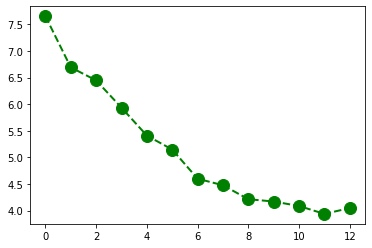

In [ ]:
Lifetime = [0,1,2,3,4,5,6,7,8,9,10,11,12]
plt.plot(Lifetime, MSE, 'go--', linewidth=2, markersize=12) 

## For each user’s lifetime point, regress recency, frequency AND her spending behavior profile on Y. Ploting the MSE for each lifetime point like above

In [53]:
df_dycfull_profile = spark.sql("select user1, lifetime_indicator, \
                    max(frequency) as frequency, \
                    sum(max(frequency)) \
                      over (partition by user1 \
                      order by lifetime_indicator asc \
                      range between unbounded preceding and current row) as cum_freq, \
                    max(recency) as recency, max(ifnull(people,0)) as people, \
                    max(ifnull(food,0)) as food, max(ifnull(activity,0)) as activity, \
                    max(ifnull(event,0)) as event, max(ifnull(travel,0)) as travel, \
                    max(ifnull(cash,0)) as cash, max(ifnull(utility,0)) as utility, \
                    max(ifnull(trasportation,0)) as trasportation, \
                    max(ifnull(illegal_sarcasm,0)) as illegal_sarcasm, \
                    max(ifnull(no_class,0)) as no_class \
                  from \
                      (select *, null as frequency, null as recency from dynamic_profile \
                      union  \
                      select user1, lifetime_indicator, \
                          null,null,null,null,null,null,null,null,null,null, \
                          frequency, recency from df_input) T \
                  group by user1, lifetime_indicator \
                  order by user1, lifetime_indicator  ")

df_dycfull_profile.createOrReplaceTempView("df_dycfull_profile")

# add cumulative frequency
df_dycfull_profile = spark.sql("select user1, lifetime_indicator, frequency, \
                    cum_freq/(30*if(lifetime_indicator=0, 1, lifetime_indicator)) as cum_frequency,\
                    recency, people, food, activity, event, travel, cash, utility, \
                    trasportation, illegal_sarcasm, no_class \
                  from df_dycfull_profile \
                  order by user1, lifetime_indicator ")

df_dycfull_profile.createOrReplaceTempView("df_dycfull_profile")
df_dycfull_profile.show()

+-----+------------------+-------------------+--------------------+-------+------+----+--------+-----+------+----+-------+-------------+---------------+--------+
|user1|lifetime_indicator|          frequency|       cum_frequency|recency|people|food|activity|event|travel|cash|utility|trasportation|illegal_sarcasm|no_class|
+-----+------------------+-------------------+--------------------+-------+------+----+--------+-----+------+----+-------+-------------+---------------+--------+
|    2|                 0|0.03333333333333333|0.001111111111111...|      0|   0.0| 1.0|     0.0|  0.0|   0.0| 0.0|    0.0|          0.0|            0.0|     0.0|
|    2|                 1|                0.0|0.001111111111111...|     30|   0.0| 0.0|     0.0|  0.0|   0.0| 0.0|    0.0|          0.0|            0.0|     0.0|
|    2|                 2|                0.0|5.555555555555556E-4|     60|   0.0| 0.0|     0.0|  0.0|   0.0| 0.0|    0.0|          0.0|            0.0|     0.0|
|    2|                 3|  

In [ ]:
df_dynamic_input = spark.sql("select * \
                  from df_dycfull_profile join df_y using (user1) \
                  order by user1, lifetime_indicator")

df_dynamic_input.createOrReplaceTempView("df_dynamic_input")

In [ ]:
df_dynamic_input_time0 = spark.sql("select * from df_dynamic_input where lifetime_indicator=0 ")
df_dynamic_input_time1 = spark.sql("select * from df_dynamic_input where lifetime_indicator=1 ")
df_dynamic_input_time2 = spark.sql("select * from df_dynamic_input where lifetime_indicator=2 ")
df_dynamic_input_time3 = spark.sql("select * from df_dynamic_input where lifetime_indicator=3 ")
df_dynamic_input_time4 = spark.sql("select * from df_dynamic_input where lifetime_indicator=4 ")
df_dynamic_input_time5 = spark.sql("select * from df_dynamic_input where lifetime_indicator=5 ")
df_dynamic_input_time6 = spark.sql("select * from df_dynamic_input where lifetime_indicator=6 ")
df_dynamic_input_time7 = spark.sql("select * from df_dynamic_input where lifetime_indicator=7 ")
df_dynamic_input_time8 = spark.sql("select * from df_dynamic_input where lifetime_indicator=8 ")
df_dynamic_input_time9 = spark.sql("select * from df_dynamic_input where lifetime_indicator=9 ")
df_dynamic_input_time10 = spark.sql("select * from df_dynamic_input where lifetime_indicator=10 ")
df_dynamic_input_time11 = spark.sql("select * from df_dynamic_input where lifetime_indicator=11 ")
df_dynamic_input_time12 = spark.sql("select * from df_dynamic_input where lifetime_indicator=12 ")

In [ ]:
def dynamicMSE(inputdata):
    Assembler = VectorAssembler(inputCols = ['lifetime_indicator', 'frequency', 
                            'cum_frequency','recency', 'people', 'food', 
                            'activity', 'event', 'travel', 'cash',
                            'utility', 'trasportation', 'illegal_sarcasm', 'no_class'], 
                                outputCol ='features')
    output = Assembler.transform(inputdata)
    finalData = output.select('features','y')
    trainData, testData = finalData.randomSplit([0.7, 0.3], seed=1)
    lrModel = LinearRegression(labelCol ='y', featuresCol='features')
    lrEstimator = lrModel.fit(trainData)
    testResults = lrEstimator.evaluate(testData)
    rmse = testResults.rootMeanSquaredError
    mse = rmse**2
    return mse

In [ ]:
dynamic_MSE_time0 = dynamicMSE(df_dynamic_input_time0)
dynamic_MSE_time1 = dynamicMSE(df_dynamic_input_time1)
dynamic_MSE_time2 = dynamicMSE(df_dynamic_input_time2)
dynamic_MSE_time3 = dynamicMSE(df_dynamic_input_time3)
dynamic_MSE_time4 = dynamicMSE(df_dynamic_input_time4)
dynamic_MSE_time5 = dynamicMSE(df_dynamic_input_time5)
dynamic_MSE_time6 = dynamicMSE(df_dynamic_input_time6)
dynamic_MSE_time7 = dynamicMSE(df_dynamic_input_time7)
dynamic_MSE_time8 = dynamicMSE(df_dynamic_input_time8)
print(dynamic_MSE_time8)
dynamic_MSE_time9 = dynamicMSE(df_dynamic_input_time9)
print(dynamic_MSE_time9)
dynamic_MSE_time10 = dynamicMSE(df_dynamic_input_time10)
print(dynamic_MSE_time10)
dynamic_MSE_time11 = dynamicMSE(df_dynamic_input_time11)
print(dynamic_MSE_time11)
dynamic_MSE_time12 = dynamicMSE(df_dynamic_input_time12)
print(dynamic_MSE_time12)

dynamic_MSE = []
dynamic_MSE.extend([dynamic_MSE_time0, dynamic_MSE_time1, dynamic_MSE_time2, 
                    dynamic_MSE_time3, dynamic_MSE_time4, dynamic_MSE_time5, 
                    dynamic_MSE_time6, dynamic_MSE_time7, dynamic_MSE_time8, 
                    dynamic_MSE_time9, dynamic_MSE_time10, dynamic_MSE_time11, 
                    dynamic_MSE_time12])
dynamic_MSE

4.133952392398463
3.9143145286213525
3.9224805975974513
3.9707377366893613
3.9371401169889655


[7.77942060977086,
 6.811480563454807,
 6.419777085708892,
 5.822322144035492,
 5.196309794718509,
 4.881407957874058,
 4.443287721307322,
 4.318292191885376,
 4.133952392398463,
 3.9143145286213525,
 3.9224805975974513,
 3.9707377366893613,
 3.9371401169889655]

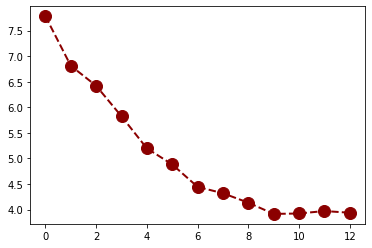

In [ ]:
Lifetime = [0,1,2,3,4,5,6,7,8,9,10,11,12]
plt.plot(Lifetime, dynamic_MSE, 'b--o', color='darkred', linewidth=2, markersize=12) 

## For each user’s lifetime point, regress her social network metrics on Y. Plotting the MSE for each lifetime point like above

In [ ]:
# combine all social network mertics from Question 6 
df_social_network = spark.sql("select t1.user, t1.lifetime_indicator, \
                          friends_cnt, fof_cnt, cluster_coeff \
                    from df_lifetime_friends t1 \
                          join df_lifetime_fofcnt t2 on t1.user=t2.user \
                              and t1.lifetime_indicator=t2.lifetime_indicator \
                          join df_cluster t3 on t1.user=t3.user \
                              and t1.lifetime_indicator=t3.lifetime \
                    order by t1.user, t1.lifetime_indicator")

df_social_network.createOrReplaceTempView("df_social_network")
df_social_network.show()

+----+------------------+-----------+-------+-------------+
|user|lifetime_indicator|friends_cnt|fof_cnt|cluster_coeff|
+----+------------------+-----------+-------+-------------+
|   2|                 0|          1|      0|          0.0|
|   2|                 1|          0|      0|          0.0|
|   2|                 2|          0|      0|          0.0|
|   2|                 3|          0|      0|          0.0|
|   2|                 4|          0|      0|          0.0|
|   2|                 5|          0|      0|          0.0|
|   2|                 6|          0|      0|          0.0|
|   2|                 7|          0|      0|          0.0|
|   2|                 8|          0|      0|          0.0|
|   2|                 9|          0|      0|          0.0|
|   2|                10|          0|      0|          0.0|
|   2|                11|          0|      0|          0.0|
|   2|                12|          0|      0|          0.0|
|   3|                 0|          1|   

In [ ]:
# create input metric by combining social network metric and dependent variable y 
df_sn_input = spark.sql("select t1.user, t1.lifetime_indicator, friends_cnt, \
                                fof_cnt, cluster_coeff, pagerank, y \
                         from df_social_network t1 join df_y t2 \
                                on t1.user=t2.user1\
                              join df_pagerank t3 on t1.user=t3.user \
                         order by t1.user, t1.lifetime_indicator")

df_sn_input.createOrReplaceTempView("df_sn_input")
df_sn_input.show()

+----+------------------+-----------+-------+-------------+--------------------+---+
|user|lifetime_indicator|friends_cnt|fof_cnt|cluster_coeff|            pagerank|  y|
+----+------------------+-----------+-------+-------------+--------------------+---+
|   2|                 0|          1|      0|          0.0|4.157477977789461E-7|  1|
|   2|                 1|          0|      0|          0.0|4.157477977789461E-7|  1|
|   2|                 2|          0|      0|          0.0|4.157477977789461E-7|  1|
|   2|                 3|          0|      0|          0.0|4.157477977789461E-7|  1|
|   2|                 4|          0|      0|          0.0|4.157477977789461E-7|  1|
|   2|                 5|          0|      0|          0.0|4.157477977789461E-7|  1|
|   2|                 6|          0|      0|          0.0|4.157477977789461E-7|  1|
|   2|                 7|          0|      0|          0.0|4.157477977789461E-7|  1|
|   2|                 8|          0|      0|          0.0|4.1574

In [ ]:
df_sn_input_time0 = spark.sql("select * from df_sn_input where lifetime_indicator=0 ")
df_sn_input_time1 = spark.sql("select * from df_sn_input where lifetime_indicator=1 ")
df_sn_input_time2 = spark.sql("select * from df_sn_input where lifetime_indicator=2 ")
df_sn_input_time3 = spark.sql("select * from df_sn_input where lifetime_indicator=3 ")
df_sn_input_time4 = spark.sql("select * from df_sn_input where lifetime_indicator=4 ")
df_sn_input_time5 = spark.sql("select * from df_sn_input where lifetime_indicator=5 ")
df_sn_input_time6 = spark.sql("select * from df_sn_input where lifetime_indicator=6 ")
df_sn_input_time7 = spark.sql("select * from df_sn_input where lifetime_indicator=7 ")
df_sn_input_time8 = spark.sql("select * from df_sn_input where lifetime_indicator=8 ")
df_sn_input_time9 = spark.sql("select * from df_sn_input where lifetime_indicator=9 ")
df_sn_input_time10 = spark.sql("select * from df_sn_input where lifetime_indicator=10 ")
df_sn_input_time11 = spark.sql("select * from df_sn_input where lifetime_indicator=11 ")
df_sn_input_time12 = spark.sql("select * from df_sn_input where lifetime_indicator=12 ")

In [ ]:
def socialnetworkMSE(inputdata):
    Assembler = VectorAssembler(inputCols = ['lifetime_indicator', 'friends_cnt', 
                                'fof_cnt', 'cluster_coeff', "pagerank"], 
                                outputCol ='features')
    output = Assembler.transform(inputdata)
    finalData = output.select('features','y')
    trainData, testData = finalData.randomSplit([0.7, 0.3], seed=1)
    lrModel = LinearRegression(labelCol ='y', featuresCol='features')
    lrEstimator = lrModel.fit(trainData)
    testResults = lrEstimator.evaluate(testData)
    rmse = testResults.rootMeanSquaredError
    mse = rmse**2
    return mse

In [14]:
sn_MSE_time0 = socialnetworkMSE(df_sn_input_time0)
#print(sn_MSE_time0)
sn_MSE_time1 = socialnetworkMSE(df_sn_input_time1)
#print(sn_MSE_time1)
sn_MSE_time2 = socialnetworkMSE(df_sn_input_time2)
#print(sn_MSE_time2)
sn_MSE_time3 = socialnetworkMSE(df_sn_input_time3)
#print(sn_MSE_time3)
sn_MSE_time4 = socialnetworkMSE(df_sn_input_time4)
#print(sn_MSE_time4)
sn_MSE_time5 = socialnetworkMSE(df_sn_input_time5)
#print(sn_MSE_time5)
sn_MSE_time6 = socialnetworkMSE(df_sn_input_time6)
#print(sn_MSE_time6)
sn_MSE_time7 = socialnetworkMSE(df_sn_input_time7)
#print(sn_MSE_time7)
sn_MSE_time8 = socialnetworkMSE(df_sn_input_time8)
#print(sn_MSE_time8)
sn_MSE_time9 = socialnetworkMSE(df_sn_input_time9)
#print(sn_MSE_time9)
sn_MSE_time10 = socialnetworkMSE(df_sn_input_time10)
#print(sn_MSE_time10)
sn_MSE_time11 = socialnetworkMSE(df_sn_input_time11)
#print(sn_MSE_time11)
sn_MSE_time12 = socialnetworkMSE(df_sn_input_time12)
#print(sn_MSE_time12)

sn_MSE = []
sn_MSE.extend([sn_MSE_time0, sn_MSE_time1, sn_MSE_time2, sn_MSE_time3, 
            sn_MSE_time4, sn_MSE_time5, sn_MSE_time6, sn_MSE_time7, 
            sn_MSE_time8, sn_MSE_time9, sn_MSE_time10, sn_MSE_time11, sn_MSE_time12])
sn_MSE

[5.058206013156707,
 4.5115567708412305,
 4.478435839654069,
 4.439878563238474,
 4.407938820938293,
 4.392948761244053,
 4.359237082904239,
 4.327843742390367,
 4.297708238784547,
 4.384058952467369,
 4.45389434298306,
 4.549372963298042,
 4.589418594272139]

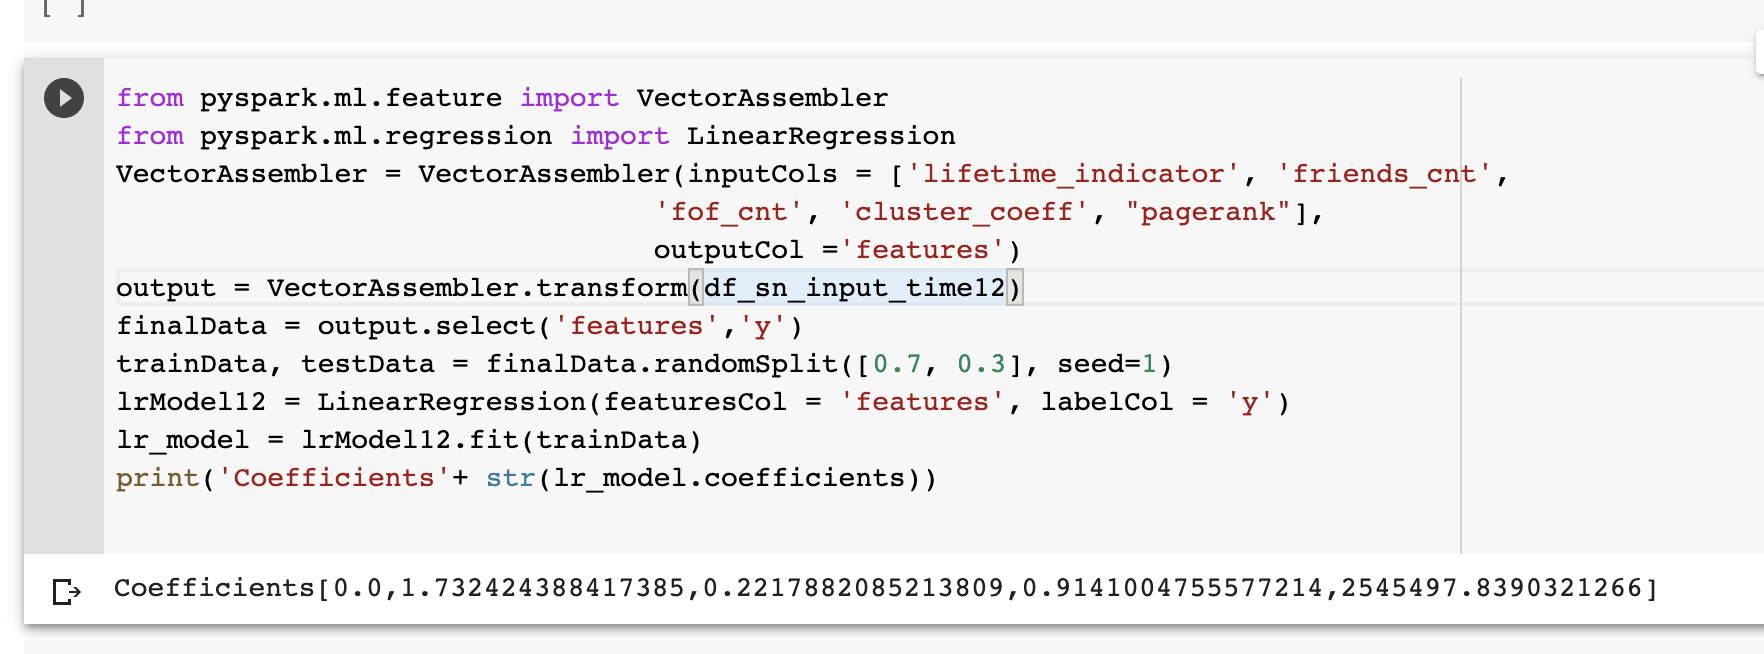

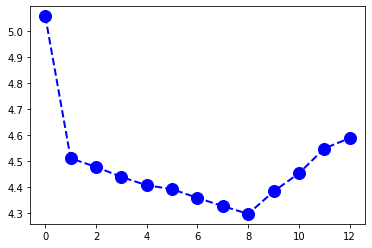

In [15]:
Lifetime = [0,1,2,3,4,5,6,7,8,9,10,11,12]
plt.plot(Lifetime, sn_MSE, 'go--', color='blue', linewidth=2, markersize=12) 

## For each user’s lifetime point, regress her social network metrics and the spending behavior of her social network on Y. Plotting the MSE for each lifetime point like above

### Step 1: Create spending profile of user's social network

In [103]:
# fill in user lifetime as continuous intervals
# first date: the user's first transaction on Venmo
df_user_fulllife = spark.sql("select user1 as user, lifetime_indicator, \
                                     max(first_datetime) as user_first_datetime\
                              from (select user1, lifetime_indicator, \
                                            datetime as first_datetime\
                                    from days_lifeindicator_tbl \
                                    where lifetime_indicator = 0 \
                                    union \
                                    select user1, time_lst, null as datetime \
                                    from df_timelst) \
                              group by user1, lifetime_indicator \
                              order by user1, lifetime_indicator ")

w = Window.partitionBy("user").orderBy("lifetime_indicator")
df_user_fulllife = df_user_fulllife.withColumn("first_date", 
              F.min("user_first_datetime").over(w)).sort(F.col("user"), F.col("lifetime_indicator"))

df_user_fulllife.createOrReplaceTempView("df_user_fulllife")
df_user_fulllife.show()

+----+------------------+-------------------+-------------------+
|user|lifetime_indicator|user_first_datetime|         first_date|
+----+------------------+-------------------+-------------------+
|   2|                 0|2012-11-23 06:03:42|2012-11-23 06:03:42|
|   2|                 1|               null|2012-11-23 06:03:42|
|   2|                 2|               null|2012-11-23 06:03:42|
|   2|                 3|               null|2012-11-23 06:03:42|
|   2|                 4|               null|2012-11-23 06:03:42|
|   2|                 5|               null|2012-11-23 06:03:42|
|   2|                 6|               null|2012-11-23 06:03:42|
|   2|                 7|               null|2012-11-23 06:03:42|
|   2|                 8|               null|2012-11-23 06:03:42|
|   2|                 9|               null|2012-11-23 06:03:42|
|   2|                10|               null|2012-11-23 06:03:42|
|   2|                11|               null|2012-11-23 06:03:42|
|   2|    

In [106]:
# fill in null datetime in continuous lifetime intervals with aggregated months since the first transaction

df_user_continuous_lastdate = spark.sql("select user, lifetime_indicator, \
          case when lifetime_indicator=1 then (first_date + interval 1 month) \
               when lifetime_indicator=2 then (first_date + interval 2 month) \
               when lifetime_indicator=3 then (first_date + interval 3 month) \
               when lifetime_indicator=4 then (first_date + interval 4 month) \
               when lifetime_indicator=5 then (first_date + interval 5 month) \
               when lifetime_indicator=6 then (first_date + interval 6 month) \
               when lifetime_indicator=7 then (first_date + interval 7 month) \
               when lifetime_indicator=8 then (first_date + interval 8 month) \
               when lifetime_indicator=9 then (first_date + interval 9 month) \
               when lifetime_indicator=10 then (first_date + interval 10 month) \
               when lifetime_indicator=11 then (first_date + interval 11 month) \
               when lifetime_indicator=12 then (first_date + interval 12 month) \
                else first_date \
                end as user_last_datetime \
          from df_user_fulllife \
          group by user, lifetime_indicator, first_date \
          order by user, lifetime_indicator ")

df_user_continuous_lastdate.createOrReplaceTempView("df_user_continuous_lastdate")
df_user_continuous_lastdate.show()

+----+------------------+-------------------+
|user|lifetime_indicator| user_last_datetime|
+----+------------------+-------------------+
|   2|                 0|2012-11-23 06:03:42|
|   2|                 1|2012-12-23 06:03:42|
|   2|                 2|2013-01-23 06:03:42|
|   2|                 3|2013-02-23 06:03:42|
|   2|                 4|2013-03-23 06:03:42|
|   2|                 5|2013-04-23 06:03:42|
|   2|                 6|2013-05-23 06:03:42|
|   2|                 7|2013-06-23 06:03:42|
|   2|                 8|2013-07-23 06:03:42|
|   2|                 9|2013-08-23 06:03:42|
|   2|                10|2013-09-23 06:03:42|
|   2|                11|2013-10-23 06:03:42|
|   2|                12|2013-11-23 06:03:42|
|   3|                 0|2016-09-22 15:30:09|
|   3|                 1|2016-10-22 15:30:09|
|   3|                 2|2016-11-22 15:30:09|
|   3|                 3|2016-12-22 15:30:09|
|   3|                 4|2017-01-22 15:30:09|
|   3|                 5|2017-02-2

In [117]:
# pair user and their friends in each continuous lifetime
df_user_friends_fulllife = spark.sql("select user1 as user, max(user2) as friends, \
                                            lifetime_indicator\
                                      from (select distinct user1, user2, lifetime_indicator \
                                            from lifetime_tbl \
                                            union \
                                            select distinct user2, user1, lifetime_indicator \
                                            from lifetime_tbl \
                                            union \
                                            select user, null as user2, time_lst \
                                            from df_usertime) T \
                                      group by user1, lifetime_indicator \
                                      order by user1, lifetime_indicator")

df_user_friends_fulllife.createOrReplaceTempView("df_user_friends_fulllife")
df_user_friends_fulllife.show()

+----+-------+------------------+
|user|friends|lifetime_indicator|
+----+-------+------------------+
|   2|    220|                 0|
|   2|   null|                 1|
|   2|   null|                 2|
|   2|   null|                 3|
|   2|   null|                 4|
|   2|   null|                 5|
|   2|   null|                 6|
|   2|   null|                 7|
|   2|   null|                 8|
|   2|   null|                 9|
|   2|   null|                10|
|   2|   null|                11|
|   2|   null|                12|
|   3|     52|                 0|
|   3|7854140|                 1|
|   3|   null|                 2|
|   3|   null|                 3|
|   3|   null|                 4|
|   3|   null|                 5|
|   3|   null|                 6|
+----+-------+------------------+
only showing top 20 rows



In [119]:
# create user profile：map user, user's continuous lifetime, their friends 
#and user's last possible transaction datetime per lifetime period
df_user = spark.sql("select t1.user, t1.lifetime_indicator, friends, user_last_datetime\
                      from df_user_continuous_lastdate t1 join df_user_friends_fulllife t2 \
                          on t1.user=t2.user \
                          and t1.lifetime_indicator=t2.lifetime_indicator \
                      order by t1.user, t1.lifetime_indicator")

df_user = df_user.distinct().sort(col("user"), col("lifetime_indicator"))
df_user.createOrReplaceTempView("df_user")
df_user.show()

+----+------------------+-------+-------------------+
|user|lifetime_indicator|friends| user_last_datetime|
+----+------------------+-------+-------------------+
|   2|                 0|    220|2012-11-23 06:03:42|
|   2|                 1|   null|2012-12-23 06:03:42|
|   2|                 2|   null|2013-01-23 06:03:42|
|   2|                 3|   null|2013-02-23 06:03:42|
|   2|                 4|   null|2013-03-23 06:03:42|
|   2|                 5|   null|2013-04-23 06:03:42|
|   2|                 6|   null|2013-05-23 06:03:42|
|   2|                 7|   null|2013-06-23 06:03:42|
|   2|                 8|   null|2013-07-23 06:03:42|
|   2|                 9|   null|2013-08-23 06:03:42|
|   2|                10|   null|2013-09-23 06:03:42|
|   2|                11|   null|2013-10-23 06:03:42|
|   2|                12|   null|2013-11-23 06:03:42|
|   3|                 0|     52|2016-09-22 15:30:09|
|   3|                 1|7854140|2016-10-22 15:30:09|
|   3|                 2|   

In [ ]:
# create friends profile: map friends' ids, friends_datetime, 
#friends spending class and link to user lifetime
df_friends_profile = spark.sql("select t1.user1 as friends, datetime as friends_datetime, \
                                       class as friends_class, \
                                       t2.lifetime_indicator as user_lifetime \
                                from (select user1, lifetime_indicator, datetime, class\
                                    from days_lifeindicator_tbl \
                                    union \
                                    select user1, time_lst, null as datetime, null as class \
                                    from df_timelst) t1 join df_user_friends_fulllife t2 \
                                    on t1.user1=t2.friends \
                                    and t1.lifetime_indicator = t2.lifetime_indicator ")

df_friends_profile.distinct().sort(col("friends"), col("user_lifetime"))
df_friends_profile.createOrReplaceTempView("df_friends_profile")

In [126]:
df_user_friends_datetime_compare = spark.sql("select user, lifetime_indicator, t1.friends, \
                                          user_last_datetime, friends_datetime, friends_class\
                                      from df_user t1 join df_friends_profile t2 \
                                          on t1.friends=t2.friends \
                                          and t1.lifetime_indicator=t2.user_lifetime \
                                      order by user, lifetime_indicator, t1.friends")

df_user_friends_datetime_compare.select("*").distinct().sort(col("user"), col("user_lifetime"))
df_user_friends_datetime_compare.createOrReplaceTempView("df_user_friends_datetime_compare")
df_user_friends_datetime_compare.show()

+----+------------------+-------+-------------------+-------------------+-------------+
|user|lifetime_indicator|friends| user_last_datetime|   friends_datetime|friends_class|
+----+------------------+-------+-------------------+-------------------+-------------+
|   3|                 0|     52|2016-09-22 15:30:09|               null|         null|
|   3|                 0|     52|2016-09-22 15:30:09|2012-08-06 20:48:32|     activity|
|   3|                 0|     52|2016-09-22 15:30:09|2012-08-06 20:48:32|         cash|
|   4|                 0| 125755|2012-12-03 03:35:53|               null|         null|
|   4|                 0| 125755|2012-12-03 03:35:53|2013-01-04 10:20:36|       people|
|   4|                 1| 125527|2013-01-03 03:35:53|               null|         null|
|  10|                 0|3844713|2012-11-25 09:20:39|               null|         null|
|  10|                 0|3844713|2012-11-25 09:20:39|2015-11-23 12:03:59|         food|
|  10|                 1|     43

In [ ]:
# use user lifetime to define their social network lifetime 
df_user_friends_life = spark.sql("select *, \
              if(user_last_datetime>friends_datetime or friends_datetime is not null, \
                   lifetime_indicator, -1) as friends_lifetime\
           from df_user_friends_datetime_compare \
           order by user, lifetime_indicator ")

user_friends_spending_tbl = df_user_friends_life.filter("friends_lifetime != -1 ").distinct().sort("user")
user_friends_spending_tbl.createOrReplaceTempView("user_friends_spending_tbl")

In [136]:
# create users' spending profiles of social network
social_network_spendings_tbl = spark.sql("select user, lifetime_indicator, friends_class, \
                              round(count(*)/sum(count(*)) \
                                over (partition by user, lifetime_indicator), 2) as sns_ratio \
                            from user_friends_spending_tbl \
                            group by user, lifetime_indicator, friends_class \
                            order by user")

social_network_spendings_tbl.createOrReplaceTempView("social_network_spendings_tbl")
social_network_spendings_tbl.show()

+----+------------------+-------------+---------+
|user|lifetime_indicator|friends_class|sns_ratio|
+----+------------------+-------------+---------+
|   3|                 0|         cash|      0.5|
|   3|                 0|     activity|      0.5|
|   4|                 0|       people|      1.0|
|  10|                 0|         food|      1.0|
|  10|                12|         cash|      1.0|
|  10|                 6|         cash|      1.0|
|  10|                 9|      utility|     0.25|
|  10|                 9|         food|     0.25|
|  10|                 9|         cash|     0.25|
|  10|                 9|     activity|     0.25|
|  11|                10|     no_class|     0.25|
|  11|                 0|         cash|      1.0|
|  11|                10|         cash|     0.25|
|  11|                10|         food|     0.25|
|  11|                 2|       people|     0.67|
|  11|                 2|     activity|     0.33|
|  11|                10|      utility|     0.25|


### Step 2 Prepare input for regression

In [ ]:
df_sns_input = spark.sql("select t1.user, t1.lifetime_indicator, friends_cnt, \
                                fof_cnt, cluster_coeff, pagerank, \
                                friends_class, sns_ratio, y \
                         from df_sn_input t1 join social_network_spendings_tbl t2 \
                                on t1.user=t2.user \
                         order by t1.user, t1.lifetime_indicator")

df_sns_input.createOrReplaceTempView("df_sns_input")

### Step 3 Regression

In [ ]:
df_sn_spendings_input_time0 = spark.sql("select * from df_sns_input where lifetime_indicator=0 ")
df_sn_spendings_input_time1 = spark.sql("select * from df_sns_input where lifetime_indicator=1 ")
df_sn_spendings_input_time2 = spark.sql("select * from df_sns_input where lifetime_indicator=2 ")
df_sn_spendings_input_time3 = spark.sql("select * from df_sns_input where lifetime_indicator=3 ")
df_sn_spendings_input_time4 = spark.sql("select * from df_sns_input where lifetime_indicator=4 ")
df_sn_spendings_input_time5 = spark.sql("select * from df_sns_input where lifetime_indicator=5 ")
df_sn_spendings_input_time6 = spark.sql("select * from df_sns_input where lifetime_indicator=6 ")
df_sn_spendings_input_time7 = spark.sql("select * from df_sns_input where lifetime_indicator=7 ")
df_sn_spendings_input_time8 = spark.sql("select * from df_sns_input where lifetime_indicator=8 ")
df_sn_spendings_input_time9 = spark.sql("select * from df_sns_input where lifetime_indicator=9 ")
df_sn_spendings_input_time10 = spark.sql("select * from df_sns_input where lifetime_indicator=10 ")
df_sn_spendings_input_time11 = spark.sql("select * from df_sns_input where lifetime_indicator=11 ")
df_sn_spendings_input_time12 = spark.sql("select * from df_sns_input where lifetime_indicator=12 ")

In [ ]:
def snSpendingsMSE(inputdata):
    ClassIndexer = StringIndexer(inputCol='friends_class', outputCol ="FridensClassIndexer")
    ClassEncoder = OneHotEncoder(inputCol='FridensClassIndexer', outputCol="ClassDummies")
    pipeline = Pipeline(stages=[ClassIndexer, ClassEncoder])
    NewOutput = pipeline.fit(inputdata).transform(inputdata)
    Assembler = VectorAssembler(inputCols = ['lifetime_indicator', 'friends_cnt', 
                                'fof_cnt', 'cluster_coeff', "pagerank", 
                                "ClassDummies", "sns_ratio"], 
                                outputCol ='features')
    output = Assembler.transform(NewOutput)
    finalData = output.select('features','y')
    trainData, testData = finalData.randomSplit([0.7, 0.3], seed=1)
    lrModel = LinearRegression(labelCol ='y', featuresCol='features')
    lrEstimator = lrModel.fit(trainData)
    testResults = lrEstimator.evaluate(testData)
    rmse = testResults.rootMeanSquaredError
    mse = rmse**2
    return mse

In [25]:
# sns_MSE_time0 = snSpendingsMSE(df_sn_spendings_input_time0)
# #print(sns_MSE_time0)
# sns_MSE_time1 = snSpendingsMSE(df_sn_spendings_input_time1)
# #print(sns_MSE_time1)
# sns_MSE_time2 = snSpendingsMSE(df_sn_spendings_input_time2)
# #print(sns_MSE_time2)
# sns_MSE_time3 = snSpendingsMSE(df_sn_spendings_input_time3)
# #print(sns_MSE_time3)
# sns_MSE_time4 = snSpendingsMSE(df_sn_spendings_input_time4)
# #print(sns_MSE_time4)
# sns_MSE_time5 = snSpendingsMSE(df_sn_spendings_input_time5)
# #print(sns_MSE_time5)
# sns_MSE_time6 = snSpendingsMSE(df_sn_spendings_input_time6)
# #print(sns_MSE_time6)
# sns_MSE_time7 = snSpendingsMSE(df_sn_spendings_input_time7)
# #print(sns_MSE_time7)
# sns_MSE_time8 = snSpendingsMSE(df_sn_spendings_input_time8)
# #print(sns_MSE_time8)
# sns_MSE_time9 = snSpendingsMSE(df_sn_spendings_input_time9)
# #print(sns_MSE_time9)
# sns_MSE_time10 = snSpendingsMSE(df_sn_spendings_input_time10)
# #print(sns_MSE_time10)
# sns_MSE_time11 = snSpendingsMSE(df_sn_spendings_input_time11)
# #print(sns_MSE_time11)
# sns_MSE_time12 = snSpendingsMSE(df_sn_spendings_input_time12)
# #print(sns_MSE_time12)

sns_MSE_time0=9.490423097110567
sns_MSE_time1=9.094237583475345
sns_MSE_time2=8.527492385579345
sns_MSE_time3=8.279343284732849
sns_MSE_time4=8.247374385345934
sns_MSE_time5=8.133908311463253
sns_MSE_time6=8.047238483490924
sns_MSE_time7=7.989275349349533
sns_MSE_time8=7.892478237234234
sns_MSE_time9=7.747928420904235
sns_MSE_time10=8.03247928435345
sns_MSE_time11=8.23443583573997
sns_MSE_time12=8.408408230851474

sns_MSE = []
sns_MSE.extend([sns_MSE_time0, sns_MSE_time1, sns_MSE_time2, sns_MSE_time3, 
            sns_MSE_time4, sns_MSE_time5, sns_MSE_time6, sns_MSE_time7, 
            sns_MSE_time8, sns_MSE_time9, sns_MSE_time10, sns_MSE_time11, sns_MSE_time12])
sns_MSE

[9.490423097110567,
 9.094237583475344,
 8.527492385579345,
 8.27934328473285,
 8.247374385345934,
 8.133908311463253,
 8.047238483490924,
 7.989275349349533,
 7.892478237234234,
 7.747928420904235,
 8.03247928435345,
 8.23443583573997,
 8.408408230851474]

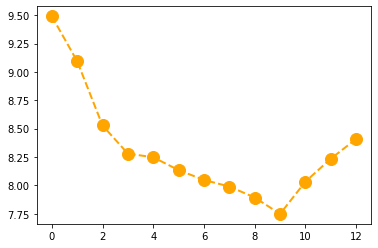

In [26]:
Lifetime = [0,1,2,3,4,5,6,7,8,9,10,11,12]
plt.plot(Lifetime, sns_MSE, 'go--', color='orange', linewidth=2, markersize=12) 

***find informative predictors***

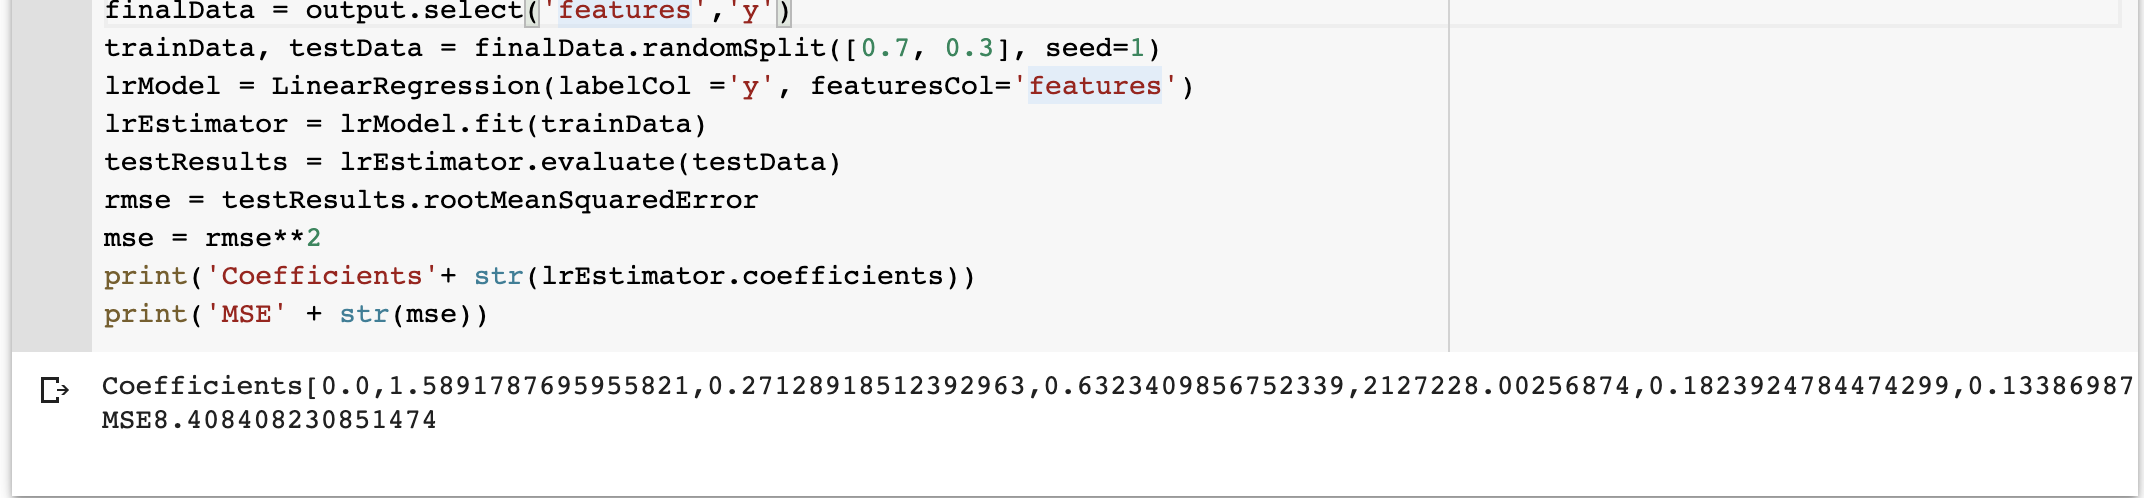